# Functional Connectivity Analysis Stim. vs. Resting
### Betweenness Centrality
### Mann Whitney U Test
### Circle connectivity & P-value Plots

In [1]:
import os
import mne
import sys
from mne.datasets import fetch_fsaverage
from pathlib import Path
from tabulate import tabulate
fs_dir = fetch_fsaverage(verbose=True)
subject = "fsaverage"
subjects_dir = os.path.dirname(fs_dir)
import random
import numpy as np
from autoreject import AutoReject

sys.path.append("C:/Users/EISERK01/eeg-projects/Code/eeg_toolkit")
from eeg_toolkit import utils, preprocess
import eeg_toolkit.functional_connectivity as fc


0 files missing from root.txt in C:\Users\EISERK01\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\EISERK01\mne_data\MNE-fsaverage-data\fsaverage
0 files missing from root.txt in C:\Users\EISERK01\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\EISERK01\mne_data\MNE-fsaverage-data\fsaverage


### Paths

In [2]:
sl_method = 'MNE'

In [3]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / f"Source Time Courses ({sl_method})"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Widespread_Pain"
# subset = "FFT Permuted Data"
fc_path = data_dir / f"Functional Connectivity ({sl_method})"
fc_subset_path = fc_path / subset if subset=="FFT Permuted Data" else fc_path
save_path = fc_subset_path

os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


### Manually enter age/sex matched subjects

In [4]:
# All CP and HC subs
sub_ids_CP = [  
    '018',  
    '020',  
    '021',  
    '027',  
    '031',  
    '032',  
    '033',  
    '035',  
    '036',  
    '037',  
    '038',  
    '040',  
    '043',  
    '044',  
    '048',  
    '049',  
    '050',  
    '057',  
    '059',
]

sub_ids_HC = [
    'C10',  
    'C11',  
    'C12',  
    'C13',  
    'C14',  
    'C15',  
    'C16',  
    'C17',  
    'C18',  
    'C19',  
    'C2.',  
    'C24',  
    'C25',  
    'C26',  
    'C27',  
    'C3.',  
    'C6.',  
    'C7.',  
    'C9.'  
]
  
sub_ids = sub_ids_CP + sub_ids_HC

# CP Subs with widespread pain
sub_ids_WSP = [
    '018',
    '022',
    '024',
    '031',
    '032',
    '034',
    '036',
    '039',
    '040',
    '045',
    '046',
    '052',
]

# CP Subs with localized pain
sub_ids_LP = [  
    '020',  
    '021',  
    '023',  
    '029',  
    '031',  
    '037',  
    '041',  
    '042',  
    '048',  
    '049',  
    '050',  
    '056'  
]  

### Low Back Pain Laterality

In [5]:
left_pain_ids = [
    '016',
    '017',
    '018',
    '019',
    '020',
    '023',
    '024',
    '025',
    '027',
    '028',
    '029',
    '030',
    '032',
    '033',
    '036',
    '038',
    '045',
    '052',
    '054',
    '055',
    '057',
    '058',
]

right_pain_ids = [
    '021',
    '026',
    '031',
    '037',
    '039',
    '043',
    '044',
    '046',
    '047',
    '048',
    '049',
    '050',
    '051',
    '053',
    '056',
]

bilateral_pain_ids = [
    '022',
    '034',
    '035',
    '040',
    '041',
    '042',
    '059',
]

# Randomly assign healthy subjects to left/right/bilateral pain
lst = sub_ids_HC
random.seed(42)
left_pain_ids.extend(random.sample(lst, 8))
lst = [i for i in lst if i not in left_pain_ids]  

# Randomly assign 8 elements to right and remove them from lst  
right_pain_ids.extend(random.sample(lst, 8))
lst = [i for i in lst if i not in right_pain_ids]  
  
# Assign the remaining elements to bilateral  
bilateral_pain_ids.extend(lst)  

In [6]:
for sub_ids, group in zip([sub_ids_CP, sub_ids_WSP, sub_ids_LP, sub_ids_HC],"CP WSP LP HC".split()):  
    print(f"\n{group}")  
    for sub_pain_ids, laterality in zip([left_pain_ids, right_pain_ids, bilateral_pain_ids],"Left Right Bilateral".split()):  
        print(f"{laterality} - {len(set(sub_ids) & set(sub_pain_ids))}")  
        print(set(sub_ids) & set(sub_pain_ids))  


CP
Left - 8
{'038', '057', '032', '027', '018', '020', '033', '036'}
Right - 8
{'031', '044', '049', '043', '050', '037', '021', '048'}
Bilateral - 3
{'040', '035', '059'}

WSP
Left - 6
{'045', '024', '032', '018', '052', '036'}
Right - 3
{'031', '046', '039'}
Bilateral - 3
{'040', '034', '022'}

LP
Left - 3
{'020', '029', '023'}
Right - 7
{'031', '049', '056', '050', '037', '021', '048'}
Bilateral - 2
{'041', '042'}

HC
Left - 8
{'C10', 'C13', 'C24', 'C12', 'C18', 'C9.', 'C17', 'C11'}
Right - 8
{'C14', 'C27', 'C26', 'C25', 'C7.', 'C6.', 'C3.', 'C15'}
Bilateral - 3
{'C2.', 'C16', 'C19'}


In [7]:
# Exclude HEALTHY subjects with widespread pain
widespread_pain_HC = ['C1.','C23']
sub_ids_HC = [sub for sub in sub_ids_HC if sub not in widespread_pain_HC]

In [8]:
print(f"Chronics (all): {len(sub_ids_CP)}")
print([el for el in sub_ids_CP])
print(f"Chronics with widespread pain: {len(sub_ids_WSP)}")
print([el for el in sub_ids_WSP])
print(f"Chronics with localized pain: {len(sub_ids_LP)}")
print([sub for sub in sub_ids_LP])
print(f"Controls: {len(sub_ids_HC)}")
print([el for el in sub_ids_HC])
print(f"\nTotal (Chronics + Controls): {len(sub_ids)}")

Chronics (all): 19
['018', '020', '021', '027', '031', '032', '033', '035', '036', '037', '038', '040', '043', '044', '048', '049', '050', '057', '059']
Chronics with widespread pain: 12
['018', '022', '024', '031', '032', '034', '036', '039', '040', '045', '046', '052']
Chronics with localized pain: 12
['020', '021', '023', '029', '031', '037', '041', '042', '048', '049', '050', '056']
Controls: 19
['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2.', 'C24', 'C25', 'C26', 'C27', 'C3.', 'C6.', 'C7.', 'C9.']

Total (Chronics + Controls): 19


### Settings for conditions/bands/methods

In [9]:
# Settings

# Include intermediate stimulus?
include_LS = False

# Data properties
sfreq = 400  # Hz

# Use canonical bands or narrower bands
narrow_bands = True 

# Choose which connectivity estimates to run. "amplitude", "phase", or "both"
# method_choice = "phase"
method_choice = "both"

# Load previously saved group data
load_group_data_flag = False

# Save group data?
save_group_data_flag = True
   
# Evoked only or include resting too?
# include_resting = False
include_resting = True

# Orthogonalize AEC?
orthogonalize_AEC = True

#####################################################
# Test mode
plot_only_mode = True
plot_only_mode = False
if plot_only_mode:
    # narrow_bands = False
    # include_resting = False
    load_group_data_flag = True
    save_group_data_flag = False

### Define ROIs, frequency bands, conditions, and methods for FC

In [10]:
####################################################################
# REGIONS OF INTEREST
# Get stc only from selected labels
roi_names = [# Left
             'rostralanteriorcingulate-lh', # Left Rostral ACC
             'caudalanteriorcingulate-lh', # Left Caudal ACC
             'postcentral-lh', # Left S1,
             'insula-lh', 'superiorfrontal-lh', # Left Insula, Left DL-PFC,
             'medialorbitofrontal-lh', # Left Medial-OFC
             # Right
             'rostralanteriorcingulate-rh', # Right Rostral ACC
             'caudalanteriorcingulate-rh', # Right Caudal ACC
             'postcentral-rh', # , Right S1
             'insula-rh', 'superiorfrontal-rh', # Right Insula, Right DL-PFC
             'medialorbitofrontal-rh', # Right Medial-OFC
]

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "dACC-lh", "S1-lh", 
                "insula-lh", "dlPFC-lh", "mOFC-lh", 
                "rACC-rh", "dACC-rh", "S1-rh", 
                "insula-rh", "dlPFC-rh", "mOFC-rh", 
               ]    

####################################################################
# BANDS OF INTEREST
if not narrow_bands:
    Freq_Bands = {
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        # "alpha": [8.0, 13.0],
        # "beta": [13.0, 30.0],
        # "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        # "high-gamma": [61.5, 100.0],
    }
else:
    Freq_Bands = { # Narrower bands and overlaps
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        "alpha": [8.0, 13.0],
        "beta": [13.0, 30.0],
        "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        "high-gamma": [61.5, 100.0],
    }
band_names = [band for band in Freq_Bands]

####################################################################
# CONNECTIVITY METHODS
if method_choice == "phase":
    con_methods = ["wpli2_debiased",
                ]
elif method_choice == "amplitude":
    con_methods = [
        # "aec_pairwise",
        "aec_symmetric",
        ]
elif method_choice == "both":
    con_methods = [
    "wpli2_debiased",
    # "aec_pairwise",
    "aec_symmetric", # keep only symmetric for now
    ]
    
####################################################################
# CONDITIONS
conditions = (
    [
        "Hand 32 mN",
        "Hand 128 mN",
        "Hand 256 mN",
        "Back 32 mN",
        "Back 128 mN",
        "Back 256 mN",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        # "Hand 32 mN",
        # 'Hand LS',
        "Hand 256 mN",
        # "Back 32 mN",
        # 'Back LS',
        # "Back 256 mN",
        "Eyes Open",
        # "Eyes Closed",
    ]
)

# Choose to exclude resting state data
conditions = conditions if include_resting else [
    c for c in conditions if "Eyes" not in c
]

####################################################################
# CONDITION DICTIONARY
condition_dict = {
        "Hand 32 mN": 0,
        'Hand LS': 1,
        "Hand 256 mN": 2,
        "Back 32 mN": 3,
        'Back LS': 4,
        "Back 256 mN": 5,
        "Eyes Open": 6,
        "Eyes Closed": 7,
}

## Create epochs out of resting data for each group

In [11]:
'''epochs_with_bad_events = []
#
sub_ids_all = ['018', '020', '021', '022', '023', '024', '027', '029','031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '048', '049', '050', '052', '056', '057', '059', 'C2.', 'C3.','C24', 'C25', 'C26', 'C27']

for sub_id in sub_ids_all:
    # Load raw data for subject eyes open
    raw_resting_path = f"R:/jwanglab/jwanglabspace/George Kenefati/Chronic Low Back Pain Study/Data/Processed Data/5min/{sub_id}_eyes_open-raw.fif"
    raw_resting = mne.io.read_raw_fif(raw_resting_path, preload=True)
    print(raw_resting_path)

    # Check number of epochs needed
    label_ts = utils.unpickle_data(zscored_epochs_data_path, f"{sub_id}_epochs.pkl")
    print(len(label_ts),len(label_ts[0]),len(label_ts[0][0]))
    hand_all_label_ts, back_all_label_ts, hand_all_ratings, back_all_ratings = fc.separate_epochs_by_stim(sub_id, processed_data_path, zscored_epochs_data_path, include_LS=include_LS)
    num_epochs = len(hand_all_ratings[1])
    

    # Use MNE to split the raw data into epochs of length 20 seconds
    events = mne.make_fixed_length_events(raw_resting, duration=1.25)
    picks = mne.pick_types(raw_resting.info, eeg=True, meg=False, exclude="bads")
    epochs = mne.Epochs(raw_resting, events=events, tmin=0, tmax=1.25, picks=picks, preload=True, baseline=None, reject=None)

    # Drop bad epochs
    ar = AutoReject(random_state=42)
    _, reject_log = ar.fit_transform(epochs, return_log=True)
    bad_epochs_bool = reject_log.bad_epochs.tolist()
    dropped_epochs_list = [i for i, val in enumerate(bad_epochs_bool) if val]

    #below chunk is for visualizing the data with bad epochs marked for data-cleaning purposes
    ######################
    bad_events = []
    for i in range(0, len(events)):
        if i in dropped_epochs_list:
            print(i)
            bad_events.append(events[i])
            if i <= len(events)-2:
                bad_events.append(events[i+1])
    bad_events = np.array(bad_events)

    epochs_with_bad_events.append((epochs.copy(), bad_events))
    ######################

    epochs.drop(dropped_epochs_list)
    
    print(f"Dropped {len(dropped_epochs_list)} epochs: ", dropped_epochs_list)
    print(f"{len(epochs)} epochs remaining:", epochs)

    # Pick 10 random epochs
    epochs = epochs[np.random.choice(epochs.events.shape[0], num_epochs, replace=False)]
    print(epochs)

    # Save epochs in a fif file
    epochs.set_eeg_reference("average", projection=True)

    zepochs = mne.EpochsArray(
        epochs.get_data(),
        info=epochs.info,
        tmin=0.0,
        on_missing="ignore",
        event_id=None,
        events=epochs.events,
    )

    zepochs.save(processed_data_path / (f"{sub_id}_eyes_open-epochs.fif"), verbose=True, overwrite=True)'''

'epochs_with_bad_events = []\n#\nsub_ids_all = [\'018\', \'020\', \'021\', \'022\', \'023\', \'024\', \'027\', \'029\',\'031\', \'032\', \'033\', \'034\', \'035\', \'036\', \'037\', \'038\', \'039\', \'040\', \'041\', \'042\', \'043\', \'044\', \'045\', \'046\', \'048\', \'049\', \'050\', \'052\', \'056\', \'057\', \'059\', \'C2.\', \'C3.\',\'C24\', \'C25\', \'C26\', \'C27\']\n\nfor sub_id in sub_ids_all:\n    # Load raw data for subject eyes open\n    raw_resting_path = f"R:/jwanglab/jwanglabspace/George Kenefati/Chronic Low Back Pain Study/Data/Processed Data/5min/{sub_id}_eyes_open-raw.fif"\n    raw_resting = mne.io.read_raw_fif(raw_resting_path, preload=True)\n    print(raw_resting_path)\n\n    # Check number of epochs needed\n    label_ts = utils.unpickle_data(zscored_epochs_data_path, f"{sub_id}_epochs.pkl")\n    print(len(label_ts),len(label_ts[0]),len(label_ts[0][0]))\n    hand_all_label_ts, back_all_label_ts, hand_all_ratings, back_all_ratings = fc.separate_epochs_by_stim(sub_

### Visualize the data with bad epochs marked with red

In [12]:
'''for i in range (0, len(epochs_with_bad_events)):
    epochs = epochs_with_bad_events[i][0]
    bad_events = epochs_with_bad_events[i][1]

    epochs.plot(events=bad_events, event_color='red')'''

"for i in range (0, len(epochs_with_bad_events)):\n    epochs = epochs_with_bad_events[i][0]\n    bad_events = epochs_with_bad_events[i][1]\n\n    epochs.plot(events=bad_events, event_color='red')"

## Compute functional connectivity for each subject in each group

In [13]:
# All Chronic Pain
if not load_group_data_flag:
    sub_con_CP = {}
    for sub_id in sub_ids_CP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_CP[sub_id] = sub_avg_cons            
        
    utils.clear_display()

018
Reading stimulus labels and pain ratings for Subject 018...

*stim_labels length = 73*
*pain_ratings_raw length = 73*

Left pain, -rh is already contralateral

Computing wpli2_debiased Hand 256 mN theta for 018...
+----------------+----------------+
| Subject        | 018            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
hereeeee
Connectivity computation...


only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density fo

In [14]:
# All Chronic Pain Epochs from Resting
if not load_group_data_flag:
    sub_con_CP_epochs = {}
    for sub_id in sub_ids_CP:
        sub_avg_cons = fc.compute_sub_avg_con_epoch_test(
            sub_id,
            "Eyes Open Epochs",
            processed_data_path,
            EO_resting_data_path,
            ["wpli2_debiased"],
            ["Eyes Open Epochs"],
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_CP_epochs[sub_id] = sub_avg_cons            

    utils.clear_display()

unpickled

Computing wpli2_debiased Eyes Open Epochs theta for 018...
+----------------+------------------+
| Subject        | 018              |
+----------------+------------------+
| Condition      | Eyes Open Epochs |
+----------------+------------------+
| Num. of epochs | 1                |
+----------------+------------------+
| Band           | theta            |
+----------------+------------------+
| Method         | wpli2_debiased   |
+----------------+------------------+
hereeeee
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    com

In [15]:
# All Healthy Controls
if not load_group_data_flag:
    sub_con_HC = {}
    for sub_id in sub_ids_HC:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Healthy Controls",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_HC[sub_id] = sub_avg_cons            
        
    utils.clear_display()

C10
Reading stimulus labels and pain ratings for Subject C10...

*stim_labels length = 57*
*pain_ratings_raw length = 57*

Left pain, -rh is already contralateral

Computing wpli2_debiased Hand 256 mN theta for C10...
+----------------+----------------+
| Subject        | C10            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
hereeeee
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: 

    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
done w that
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*

Computing wpli2_debiased Hand 256 mN alpha for C10...
+----------------+----------------+
| Subject        | C10            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | alpha          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
hereeeee
Connectivity c

In [16]:
# All Healthy Control Epochs from Resting
if not load_group_data_flag:
    sub_con_HC_epochs = {}
    for sub_id in sub_ids_HC:
        sub_avg_cons = fc.compute_sub_avg_con_epoch_test(
            sub_id,
            "Eyes Open Epochs",
            processed_data_path,
            EO_resting_data_path,
            ["wpli2_debiased"],
            ["Eyes Open Epochs"],
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_HC_epochs[sub_id] = sub_avg_cons            

    utils.clear_display()

unpickled

Computing wpli2_debiased Eyes Open Epochs theta for C10...
+----------------+------------------+
| Subject        | C10              |
+----------------+------------------+
| Condition      | Eyes Open Epochs |
+----------------+------------------+
| Num. of epochs | 1                |
+----------------+------------------+
| Band           | theta            |
+----------------+------------------+
| Method         | wpli2_debiased   |
+----------------+------------------+
hereeeee
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    com

In [17]:
# CLBP with WSP
if not load_group_data_flag:
    sub_con_WSP = {}
    for sub_id in sub_ids_WSP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Widespread Pain",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_WSP[sub_id] = sub_avg_cons            
        
    utils.clear_display()

018
Reading stimulus labels and pain ratings for Subject 018...

*stim_labels length = 73*
*pain_ratings_raw length = 73*

Left pain, -rh is already contralateral

Computing wpli2_debiased Hand 256 mN theta for 018...
+----------------+----------------+
| Subject        | 018            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
hereeeee
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: 

In [18]:
# CLBP with WSP Epochs from Resting
if not load_group_data_flag:
    sub_con_WSP_epochs = {}
    for sub_id in sub_ids_WSP:
        sub_avg_cons = fc.compute_sub_avg_con_epoch_test(
            sub_id,
            "Eyes Open Epochs",
            processed_data_path,
            EO_resting_data_path,
            ["wpli2_debiased"],
            ["Eyes Open Epochs"],
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_WSP_epochs[sub_id] = sub_avg_cons            

    utils.clear_display()

unpickled

Computing wpli2_debiased Eyes Open Epochs theta for 018...
+----------------+------------------+
| Subject        | 018              |
+----------------+------------------+
| Condition      | Eyes Open Epochs |
+----------------+------------------+
| Num. of epochs | 1                |
+----------------+------------------+
| Band           | theta            |
+----------------+------------------+
| Method         | wpli2_debiased   |
+----------------+------------------+
hereeeee
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    com

In [19]:
# CLBP with Localized Pain
if not load_group_data_flag:
    sub_con_LP = {}
    for sub_id in sub_ids_LP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_LP[sub_id] = sub_avg_cons            
        
    utils.clear_display()

020
Reading stimulus labels and pain ratings for Subject 020...

*stim_labels length = 80*
*pain_ratings_raw length = 80*

Left pain, -rh is already contralateral

Computing wpli2_debiased Hand 256 mN theta for 020...
+----------------+----------------+
| Subject        | 020            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
hereeeee
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral dens

In [20]:
# CLBP with Localized Pain Epochs from Resting
if not load_group_data_flag:
    sub_con_LP_epochs = {}
    for sub_id in sub_ids_LP:
        sub_avg_cons = fc.compute_sub_avg_con_epoch_test(
            sub_id,
            "Eyes Open Epochs",
            processed_data_path,
            EO_resting_data_path,
            ["wpli2_debiased"],
            ["Eyes Open Epochs"],
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=left_pain_ids,
            right_pain_ids=right_pain_ids,
            bilateral_pain_ids=bilateral_pain_ids,
            include_LS=include_LS,
        )
        sub_con_LP_epochs[sub_id] = sub_avg_cons            

    utils.clear_display()

unpickled

Computing wpli2_debiased Eyes Open Epochs theta for 020...
+----------------+------------------+
| Subject        | 020              |
+----------------+------------------+
| Condition      | Eyes Open Epochs |
+----------------+------------------+
| Num. of epochs | 1                |
+----------------+------------------+
| Band           | theta            |
+----------------+------------------+
| Method         | wpli2_debiased   |
+----------------+------------------+
hereeeee
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    com

### Compute group connectivity

In [21]:
if not load_group_data_flag: 
    # Stack the connectivity of all subjects in each group
    group_con_WSP = fc.compute_group_con(sub_con_WSP, conditions, con_methods, band_names)
    group_con_WSP_epochs = fc.compute_group_con_epochs(sub_con_WSP_epochs, ['Eyes Open Epochs'], ['wpli2_debiased'], band_names)
    group_con_LP = fc.compute_group_con(sub_con_LP, conditions, con_methods, band_names)
    group_con_LP_epochs = fc.compute_group_con_epochs(sub_con_LP_epochs, ['Eyes Open Epochs'], ['wpli2_debiased'], band_names)
    group_con_HC = fc.compute_group_con(sub_con_HC, conditions, con_methods, band_names)
    group_con_HC_epochs = fc.compute_group_con_epochs(sub_con_HC_epochs, ['Eyes Open Epochs'], ['wpli2_debiased'], band_names)
    group_con_CP = fc.compute_group_con(sub_con_CP, conditions, con_methods, band_names)
    group_con_CP_epochs = fc.compute_group_con_epochs(sub_con_CP_epochs, ['Eyes Open Epochs'], ['wpli2_debiased'], band_names)

else:
    # Checkpoint path
    checkpoint_path = save_path / f"Checkpoints: {conditions}"
    os.makedirs(checkpoint_path, exist_ok=True)
    print(f"Loading checkpoints from {checkpoint_path}")
    
    group_con_WSP = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_WSP.pkl")
    group_con_WSP_epochs = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_WSP-epochs.pkl")
    group_con_LP = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_LP.pkl")
    group_con_LP_epochs = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_LP-epochs.pkl")
    group_con_HC = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_HC.pkl")
    group_con_HC_epochs = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_HC-epochs.pkl")
    group_con_CP = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_CP.pkl")
    group_con_CP_epochs = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_CP-epochs.pkl")
   
    sub_con_WSP = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_WSP.pkl")
    sub_con_WSP_epochs = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_WSP-epochs.pkl")
    sub_con_LP = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_LP.pkl")
    sub_con_LP_epochs = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_LP-epochs.pkl")
    sub_con_HC = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_HC.pkl")
    sub_con_HC_epochs = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_HC-epochs.pkl")
    sub_con_CP = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_CP.pkl")
    sub_con_CP_epochs = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_CP-epochs.pkl")

Group connectivity completed.
Group connectivity completed.
Group connectivity completed.
Group connectivity completed.
Group connectivity completed.
Group connectivity completed.
Group connectivity completed.
Group connectivity completed.


In [22]:
if save_group_data_flag:
    # Checkpoint path
    checkpoint_path = save_path / f"Checkpoints: {conditions}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    # Save/checkpoint as pickle
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_WSP.pkl", group_con_WSP)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_WSP-epochs.pkl", group_con_WSP_epochs)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_LP.pkl", group_con_LP)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_LP-epochs.pkl", group_con_LP_epochs)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_HC.pkl", group_con_HC)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_HC-epochs.pkl", group_con_HC_epochs)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_CP.pkl", group_con_CP)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_CP-epochs.pkl", group_con_CP_epochs)

    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_WSP.pkl", sub_con_WSP)
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_WSP-epochs.pkl", sub_con_WSP_epochs)
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_LP.pkl", sub_con_LP)
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_LP-epochs.pkl", sub_con_LP_epochs)
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_HC.pkl", sub_con_HC)
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_HC-epochs.pkl", sub_con_HC_epochs)
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_CP.pkl", sub_con_CP)
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_CP-epochs.pkl", sub_con_CP_epochs)

NotADirectoryError: [WinError 267] The directory name is invalid: "..\\..\\Data\\Functional Connectivity (MNE)\\Checkpoints: ['Hand 256 mN', 'Eyes Open']"

## Plot and compute satistics to assess statistical differences 

### Plot settings

In [23]:
# Highlight p-values with red box automatically
highlight_pvals=False

# Make any non-significant squares white
show_only_significant=True

# Set title automatically
set_title=True

# Show values in the matrix quadrants
show_fc_vals=True

# *KEEP FALSE* Round negative values to zero 
# (Vinck. et al 2011 has negative values for WPLI 2 Debiased. NO ROUNDING)
round_neg_vals=False

# Plot 3D brain visualization (for AEC only)
plot_brain=False

# Save tables to txt files
save_txt=False
# save_txt=True

## Hand vs. Resting Epochs Plots

Hand 256 mN - Eyes Open Epochs - Chronic Pain vs. Chronic Pain Resting Epochs - wpli2_debiased - theta
Top 3 Connections in Chronic Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| dACC-rh <-> dACC-lh  |   4/19    |     0.505     |
| mOFC-rh <-> dlPFC-lh |   3/19    |     0.479     |
| dlPFC-rh <-> dACC-lh |   3/19    |     0.384     |
+----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Pain Resting Epochs group
+-------------------------+-----------+---------------+
|       Connection        | Frequency | Mean Strength |
+-------------------------+-----------+---------------+
|     S1-rh <-> S1-lh     |   4/19    |     0.594     |
| insula-rh <-> insula-lh |   3/19    |     0.423     |
|    S1-rh <-> rACC-lh    |   3/19    |     0.61      |
+-------------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centralit

<Figure size 640x480 with 0 Axes>

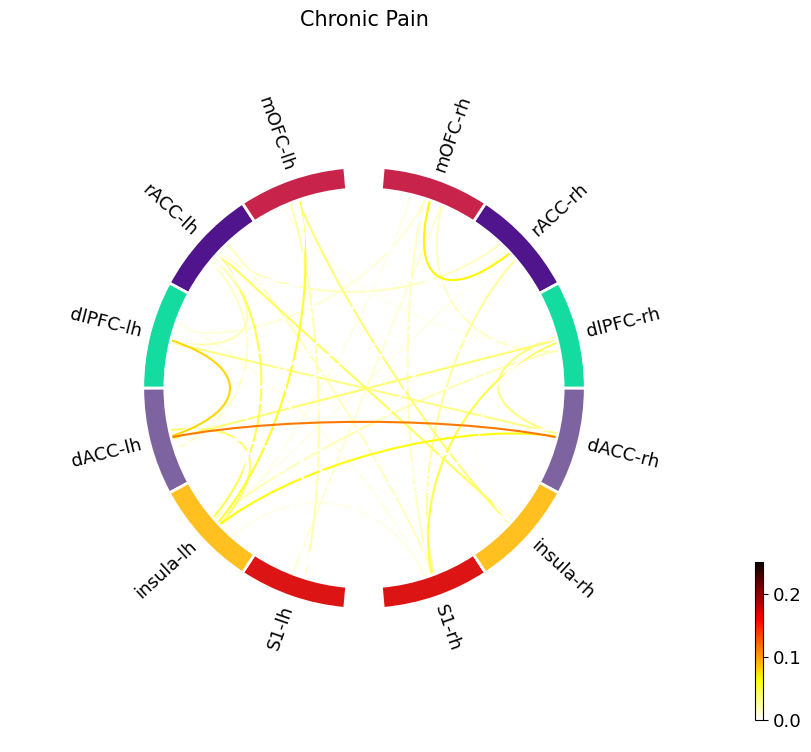

<Figure size 640x480 with 0 Axes>

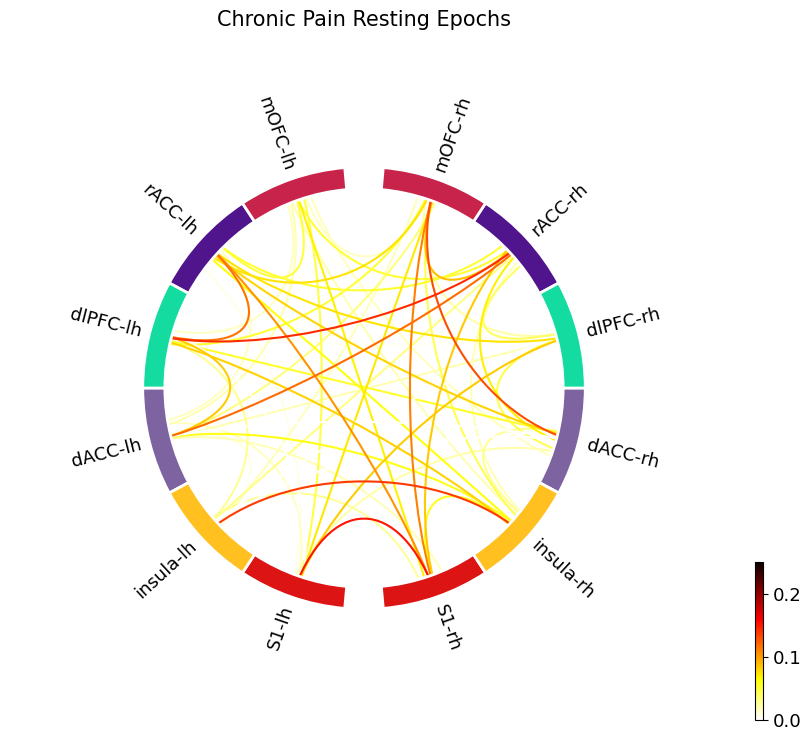

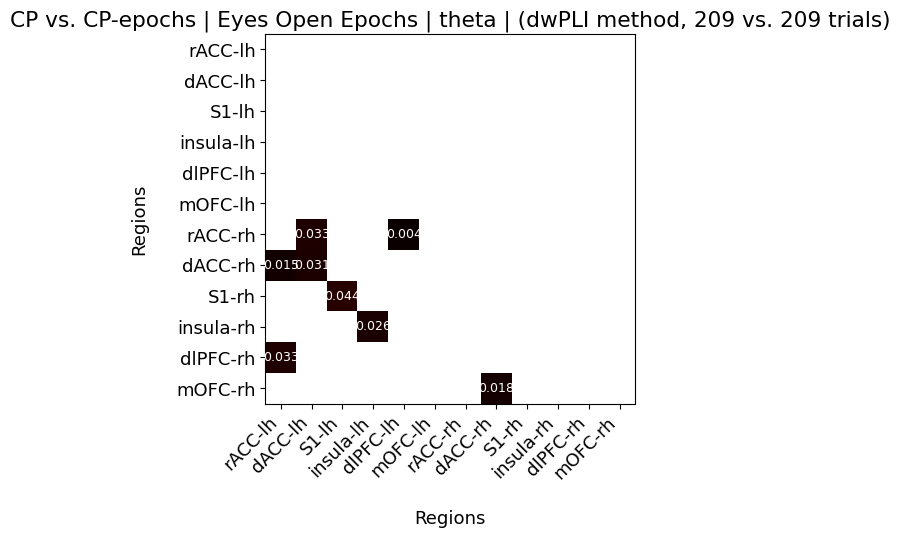

Hand 256 mN - Eyes Open Epochs - Chronic Pain vs. Chronic Pain Resting Epochs - wpli2_debiased - alpha
Top 3 Connections in Chronic Pain group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| dlPFC-rh <-> S1-rh  |   4/19    |     0.543     |
| mOFC-rh <-> mOFC-lh |   3/19    |     0.47      |
|  S1-rh <-> mOFC-lh  |   3/19    |     0.365     |
+---------------------+-----------+---------------+ 

Top 3 Connections in Chronic Pain Resting Epochs group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| mOFC-rh <-> dlPFC-rh |   4/19    |     0.474     |
|   S1-rh <-> S1-lh    |   3/19    |     0.505     |
|  S1-rh <-> dACC-lh   |   3/19    |     0.467     |
+----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+-----+--------

<Figure size 640x480 with 0 Axes>

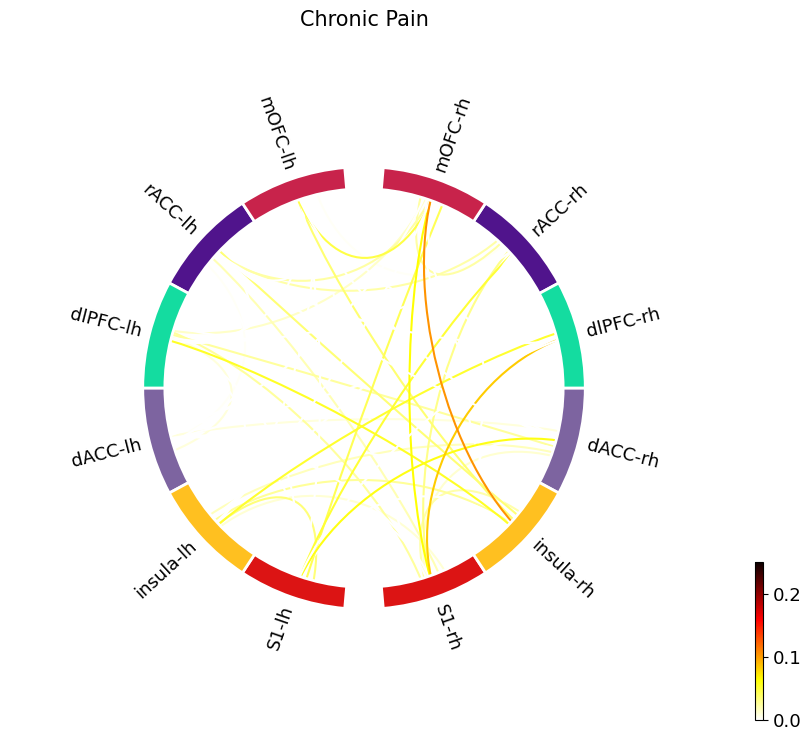

<Figure size 640x480 with 0 Axes>

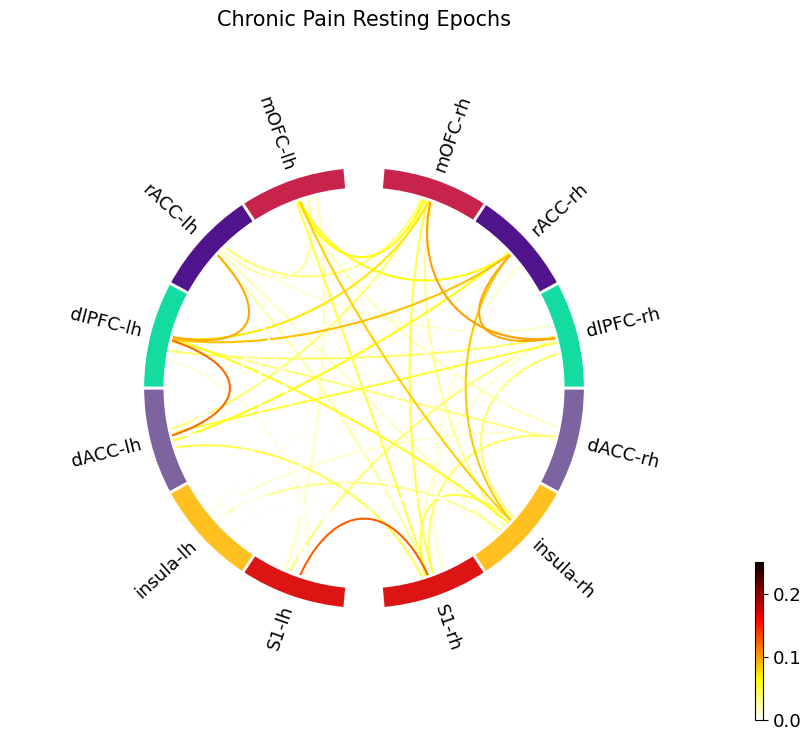

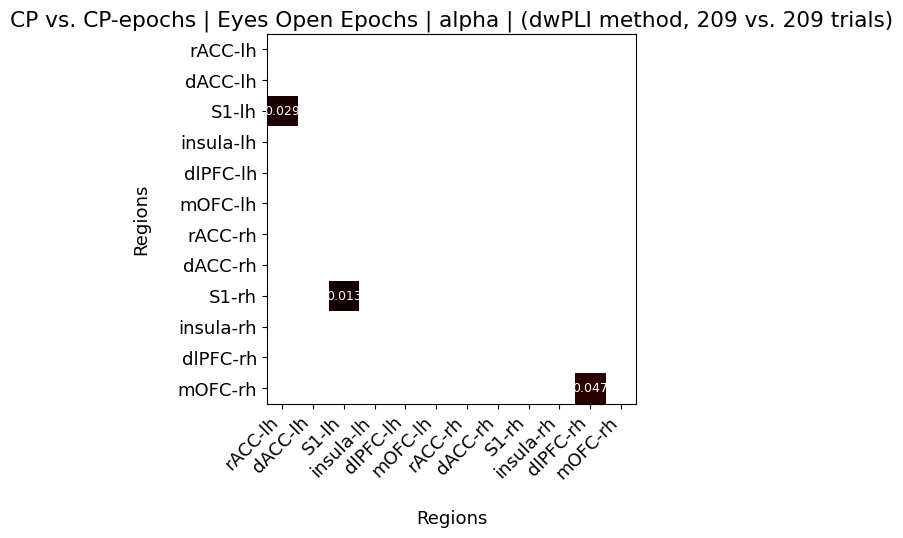

Hand 256 mN - Eyes Open Epochs - Chronic Pain vs. Chronic Pain Resting Epochs - wpli2_debiased - beta
Top 3 Connections in Chronic Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| insula-rh <-> S1-lh  |   4/19    |     0.18      |
| dlPFC-lh <-> rACC-lh |   3/19    |     0.337     |
| rACC-rh <-> dlPFC-lh |   3/19    |     0.355     |
+----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Pain Resting Epochs group
+-------------------------+-----------+---------------+
|       Connection        | Frequency | Mean Strength |
+-------------------------+-----------+---------------+
|  insula-rh <-> rACC-lh  |   4/19    |     0.224     |
|  insula-rh <-> dACC-rh  |   3/19    |     0.195     |
| insula-rh <-> insula-lh |   3/19    |     0.442     |
+-------------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality

<Figure size 640x480 with 0 Axes>

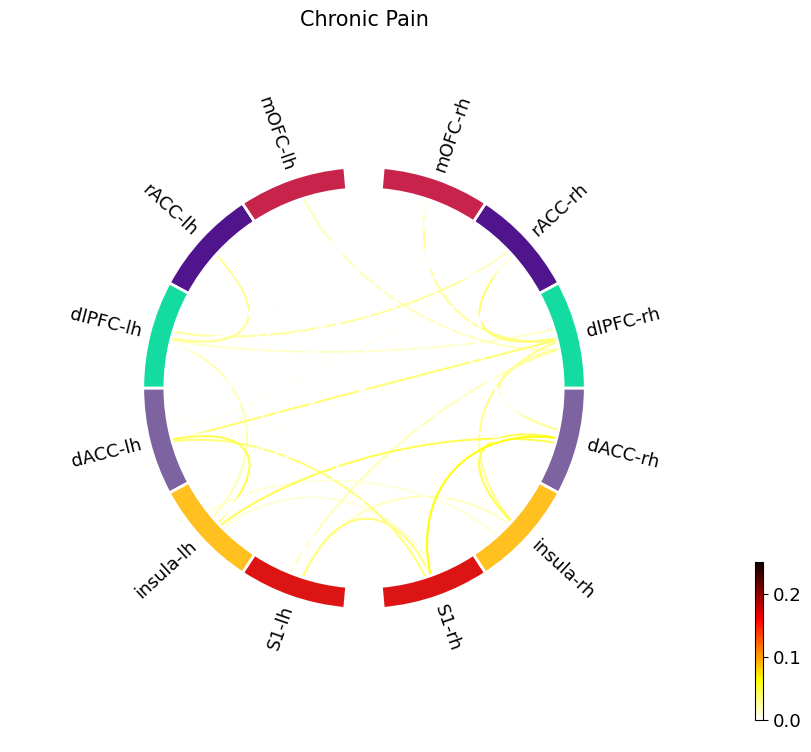

<Figure size 640x480 with 0 Axes>

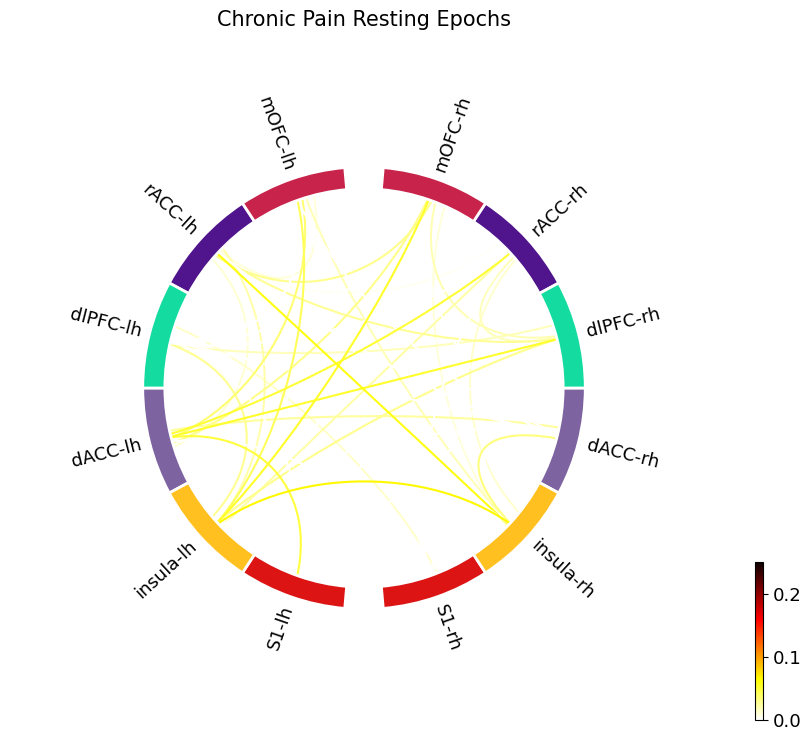

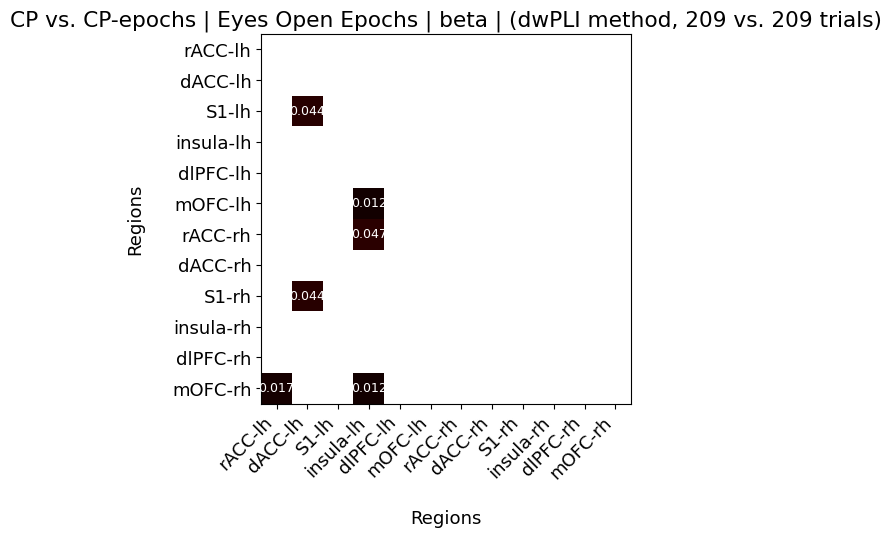

Hand 256 mN - Eyes Open Epochs - Chronic Pain vs. Chronic Pain Resting Epochs - wpli2_debiased - low-gamma
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|   rACC-rh <-> S1-lh   |   3/19    |     0.188     |
|  S1-rh <-> dlPFC-lh   |   3/19    |     0.264     |
| insula-rh <-> rACC-lh |   3/19    |     0.174     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Chronic Pain Resting Epochs group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
|  rACC-rh <-> S1-lh   |   5/19    |     0.238     |
| dlPFC-lh <-> rACC-lh |   3/19    |     0.275     |
| dlPFC-lh <-> dACC-lh |   3/19    |     0.144     |
+----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Regio

<Figure size 640x480 with 0 Axes>

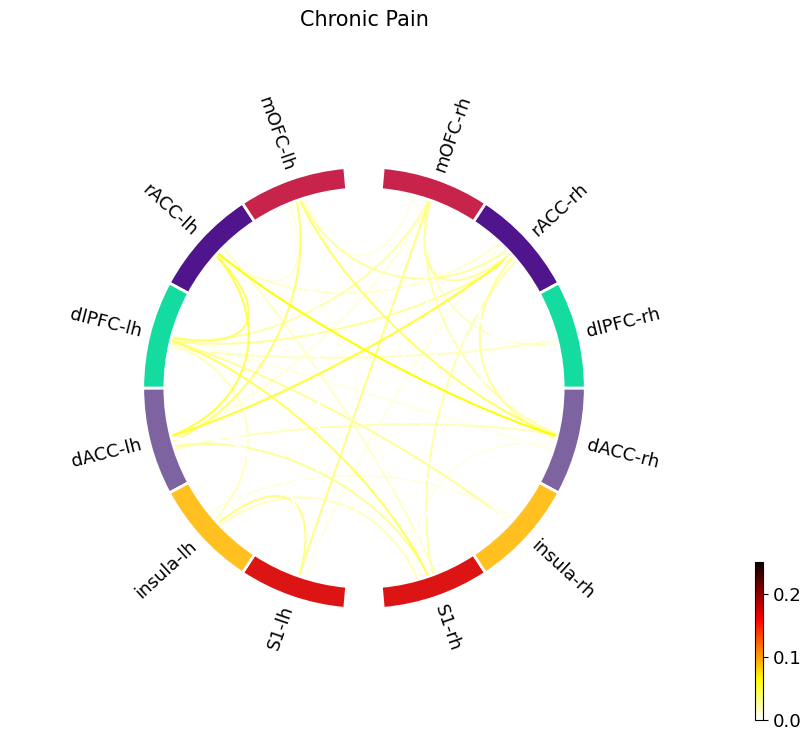

<Figure size 640x480 with 0 Axes>

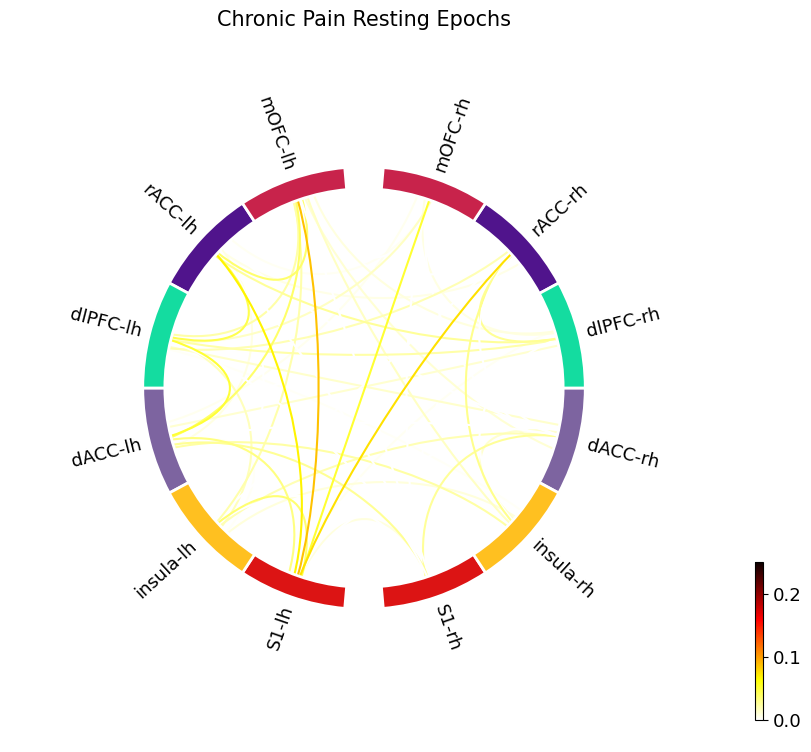

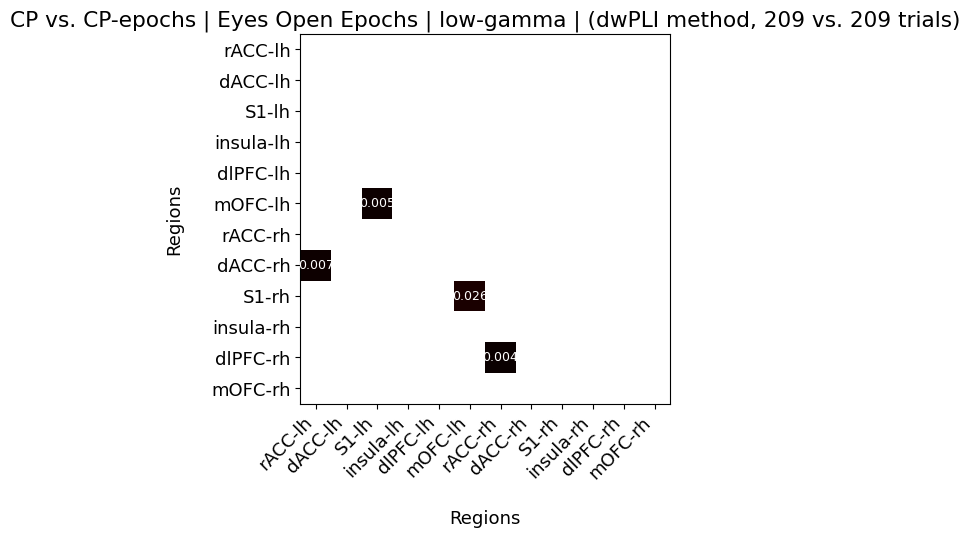

Hand 256 mN - Eyes Open Epochs - Chronic Pain vs. Chronic Pain Resting Epochs - wpli2_debiased - high-gamma
Top 3 Connections in Chronic Pain group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
| insula-rh <-> mOFC-lh  |   4/19    |     0.218     |
|  dACC-rh <-> rACC-rh   |   3/19    |     0.132     |
| dlPFC-rh <-> insula-rh |   3/19    |     0.122     |
+------------------------+-----------+---------------+ 

Top 3 Connections in Chronic Pain Resting Epochs group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-rh <-> mOFC-lh |   5/19    |     0.209     |
| dlPFC-rh <-> dlPFC-lh |   3/19    |     0.263     |
|   S1-lh <-> dACC-lh   |   3/19    |     0.155     |
+-----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Cent

<Figure size 640x480 with 0 Axes>

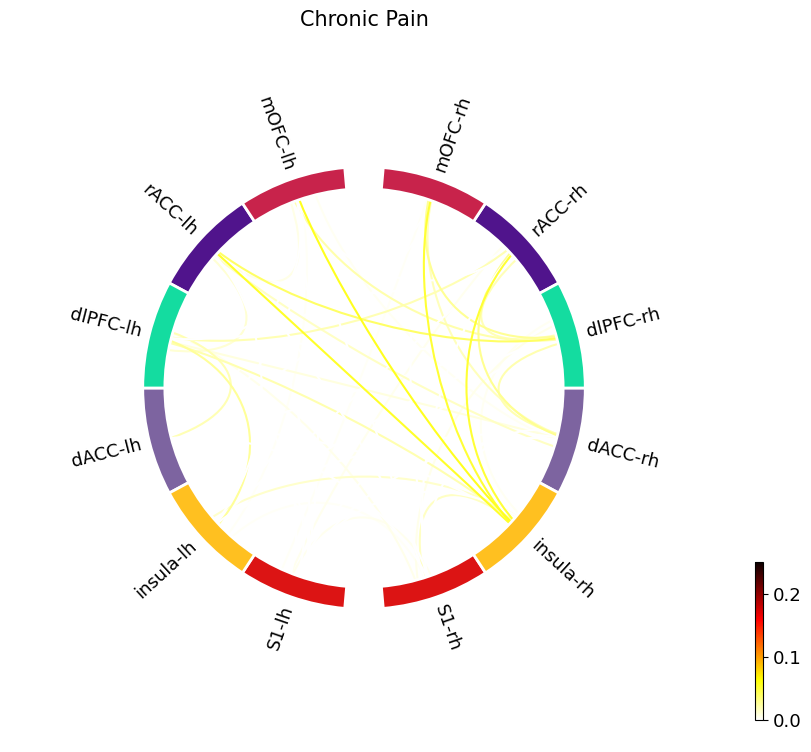

<Figure size 640x480 with 0 Axes>

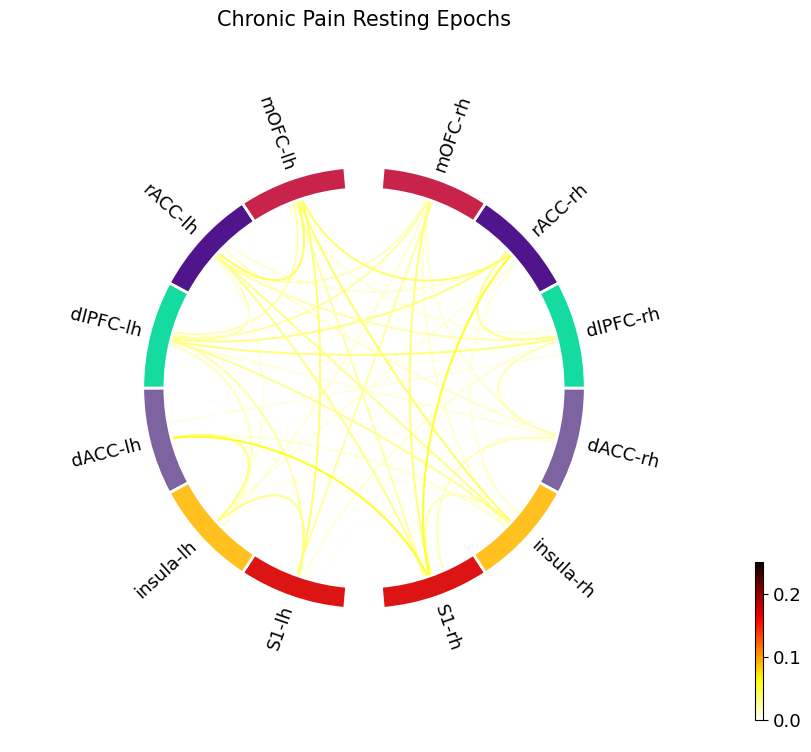

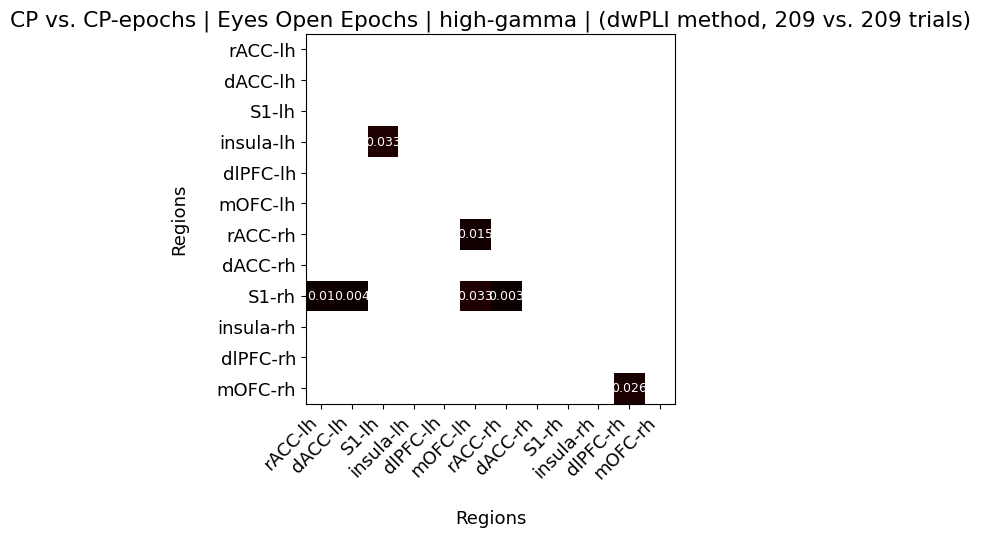

In [25]:
# Chronic Pain vs. Chronic Pain Epochs from Resting
these_group_names = ["Chronic Pain", "Chronic Pain Resting Epochs", "Mann_Whitney_U_test"]
these_group_cons = [group_con_CP, group_con_CP_epochs]
these_sub_cons = [sub_con_CP, sub_con_CP_epochs]
these_sub_ids = [sub_ids_CP, sub_ids_CP]
condition_CP =  'Hand 256 mN'
condition_CP_epochs = 'Eyes Open Epochs'
method = 'wpli2_debiased'

# Make a directory for the stats
stats_save_path = save_path / f"CP_vs_CP-epochs"
os.makedirs(stats_save_path, exist_ok=True)

for band in band_names:
    ## Save all output to a text file
    # Backup original stdout  
    orig_stdout = sys.stdout  
    if method=="wpli2_debiased":
        f = open(stats_save_path / f'{condition_CP}_{condition_CP_epochs}_{band}_dwPLI.txt', 'w')  
    else:
        f = open(stats_save_path / f'{condition_CP}_{condition_CP_epochs}_{band}_{method}.txt', 'w')
                
    # Set stdout to the file object  
    if save_txt:
        sys.stdout = f  
            
    # Select groups for mann-whitney
    print(f"{condition_CP} - {condition_CP_epochs} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
        
    # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
    top_3_info=None
    group_con=None
    for group_con,group_name,sub_con in zip(these_group_cons, these_group_names, these_sub_cons):
        table_data = []  
        if group_con == these_group_cons[0]:
            condition = condition_CP
        else:
            condition = condition_CP_epochs
        top_3_info = group_con[condition][method][band]["top 3"] 
        print(f"Top 3 Connections in {group_name} group")
        for i in range(3):  
            connection = top_3_info["connections"][i]  
            frequency = top_3_info["frequency"][i]  
            mean_strength = top_3_info["mean strength"][i]
            table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", f"{frequency}/{len(sub_con)}", mean_strength]) 
                
        # Define table headers  
        headers = ['Connection', 'Frequency', 'Mean Strength']  
                
        # Print the table  
        print(tabulate(table_data, headers, tablefmt='pretty'),'\n')  

    group1_stack = these_group_cons[0][condition_CP][method][band]["data"]
    print(group1_stack.shape)
    group2_stack = these_group_cons[1][condition_CP_epochs][method][band]["data"]

    nepochs_1 = these_group_cons[0][condition_CP]['num_epochs']
    nepochs_2 = these_group_cons[1][condition_CP_epochs]['num_epochs']
            
    # Compute the Mann-Whitney U test
    p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test_epochs(
        group1_stack,
        group2_stack,
        roi_acronyms=roi_acronyms,
        sub_ids1=these_sub_ids[0],
        sub_ids2=these_sub_ids[1],
        condition_group1=condition_CP,
        condition_group2=condition_CP_epochs,
        bilateral_pain_ids=bilateral_pain_ids,
        round_neg_vals=round_neg_vals,
        method=method)

    vmin = None
    vmax = None
            
    # Plotting
    # Gather the information for plotting
    plot_kwargs= dict(
        method=method,
        band=band, 
        roi_names=roi_names,
        roi_acronyms=roi_acronyms,
        condition=condition,
        vmin=vmin,
        vmax=vmax,
        group_names=these_group_names,
        nepochs=[nepochs_1, nepochs_2],
        titles=[these_group_names[0], 
                these_group_names[1],
                "CP vs. CP-epochs",],
        save_names=["Mann_Whitney_U_test",
                    these_group_names[0], 
                    these_group_names[1],
                    ],
            save_path=stats_save_path,
        )
            
    # Compute the centrality and test
    fc.compute_centrality_and_test(group1_stack,
                                    group2_stack, 
                                    roi_acronyms=roi_acronyms,
                                    sub_ids1=these_sub_ids[0],
                                    sub_ids2=these_sub_ids[1],
                                    bilateral_pain_ids=bilateral_pain_ids,
                                    condition=condition,
                                    )
        
    print(f"\nNum epochs: {nepochs_1} vs. {nepochs_2}")               
    fc.plot_connectivity_and_stats(means_1=means_1,
                                means_2=means_2,
                                sem_1=sem_1,
                                sem_2=sem_2,
                                p_values=p_values,
                                **plot_kwargs,
                                save_fig=True,
                                highlight_pvals=highlight_pvals,
                                min_fc_val=None,
                                set_title=set_title,
                                show_fc_vals=show_fc_vals,
                                round_neg_vals=round_neg_vals,
    )
    
        
    # Reset the standard output to its original value  
    sys.stdout = orig_stdout  
            
    f.close()  

Hand 256 mN - Eyes Open Epochs - Healthy Control vs. Healthy Control Resting Epochs - wpli2_debiased - theta
Top 3 Connections in Healthy Control group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| mOFC-rh <-> rACC-rh |   3/19    |     0.44      |
| mOFC-rh <-> mOFC-lh |   2/19    |     0.38      |
| mOFC-rh <-> rACC-lh |   2/19    |     0.443     |
+---------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control Resting Epochs group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| dlPFC-lh <-> rACC-lh |   4/19    |     0.512     |
| rACC-rh <-> rACC-lh  |   4/19    |     0.482     |
| dlPFC-lh <-> dACC-lh |   3/19    |     0.374     |
+----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+--

<Figure size 640x480 with 0 Axes>

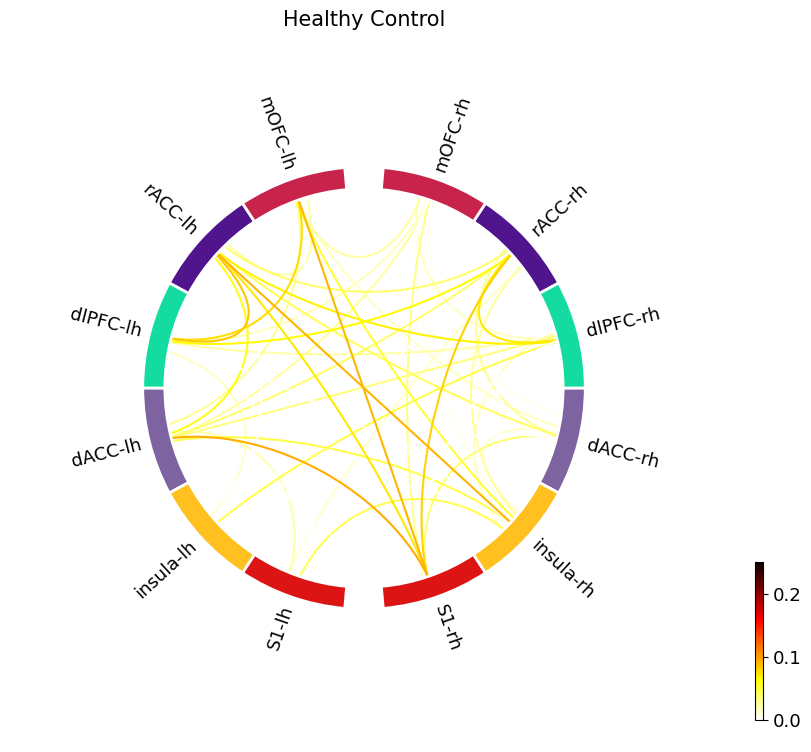

<Figure size 640x480 with 0 Axes>

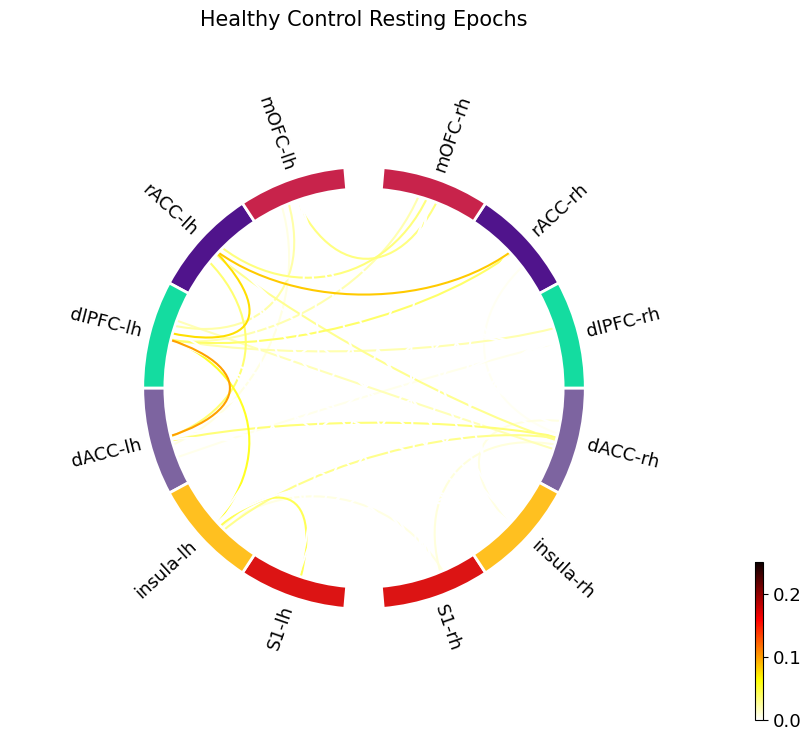

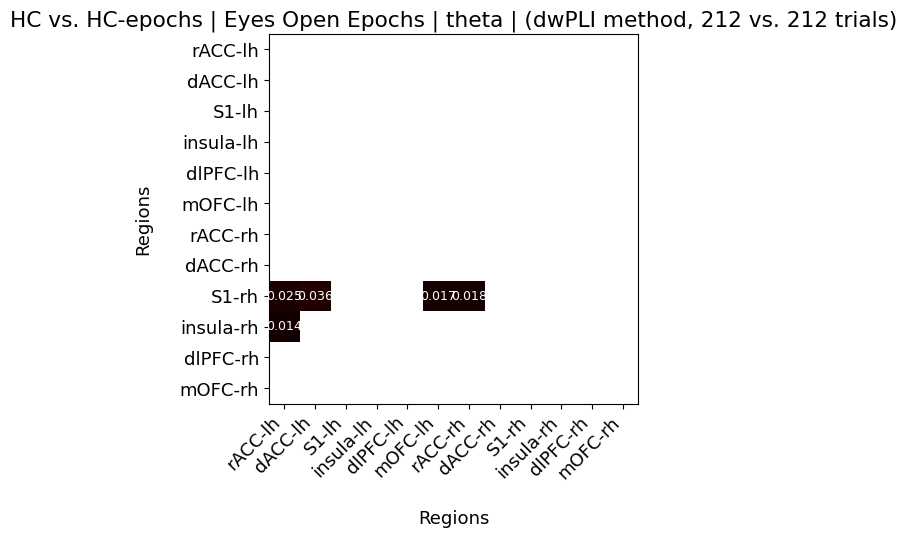

Hand 256 mN - Eyes Open Epochs - Healthy Control vs. Healthy Control Resting Epochs - wpli2_debiased - alpha
Top 3 Connections in Healthy Control group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| mOFC-lh <-> dlPFC-lh |   4/19    |     0.539     |
|  mOFC-lh <-> S1-lh   |   3/19    |     0.416     |
| insula-rh <-> S1-rh  |   2/19    |     0.636     |
+----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control Resting Epochs group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| dACC-rh <-> rACC-rh |   4/19    |     0.456     |
| mOFC-rh <-> mOFC-lh |   4/19    |     0.453     |
| dlPFC-rh <-> S1-lh  |   3/19    |     0.448     |
+---------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Region:
+--

<Figure size 640x480 with 0 Axes>

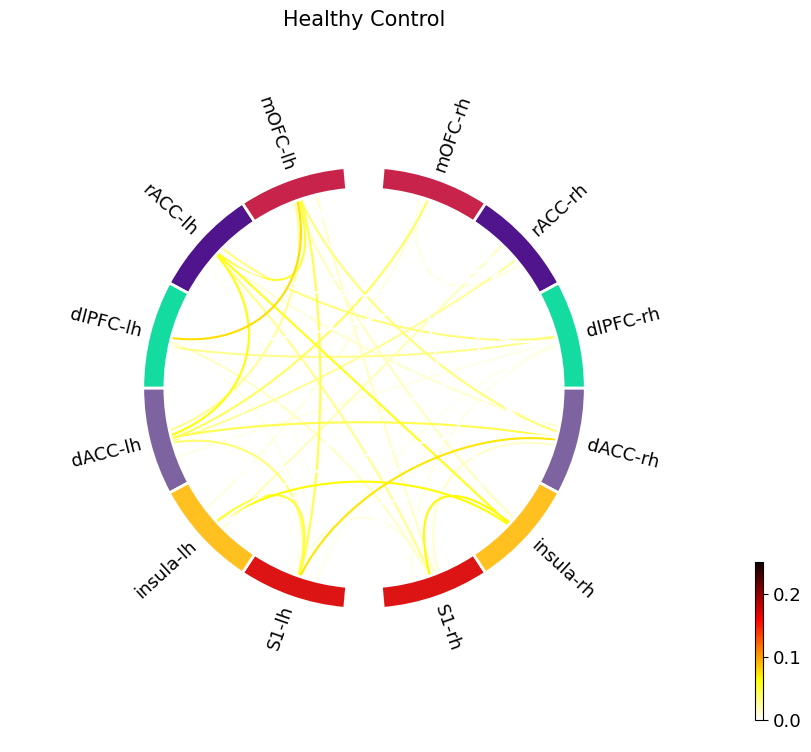

<Figure size 640x480 with 0 Axes>

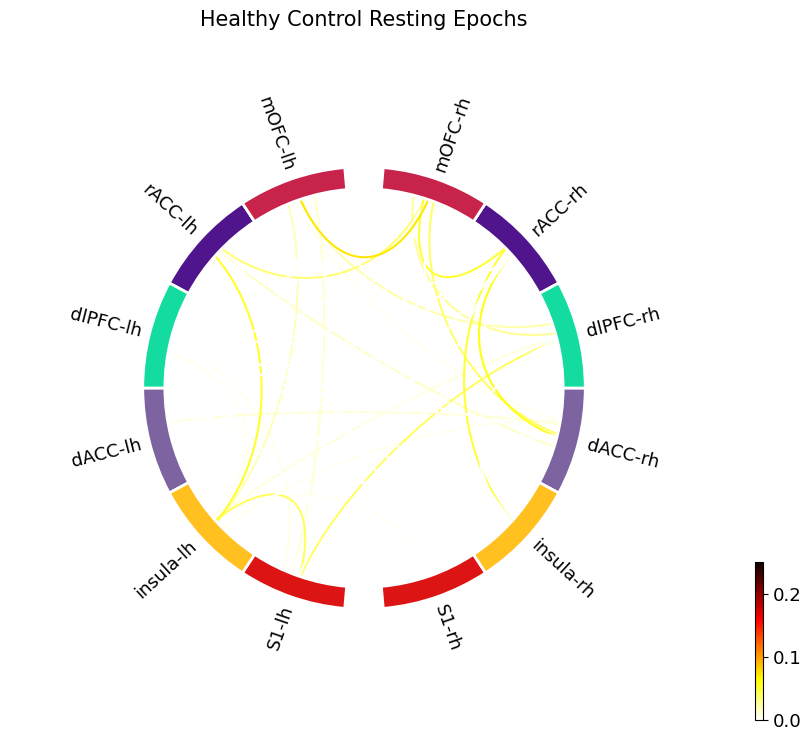

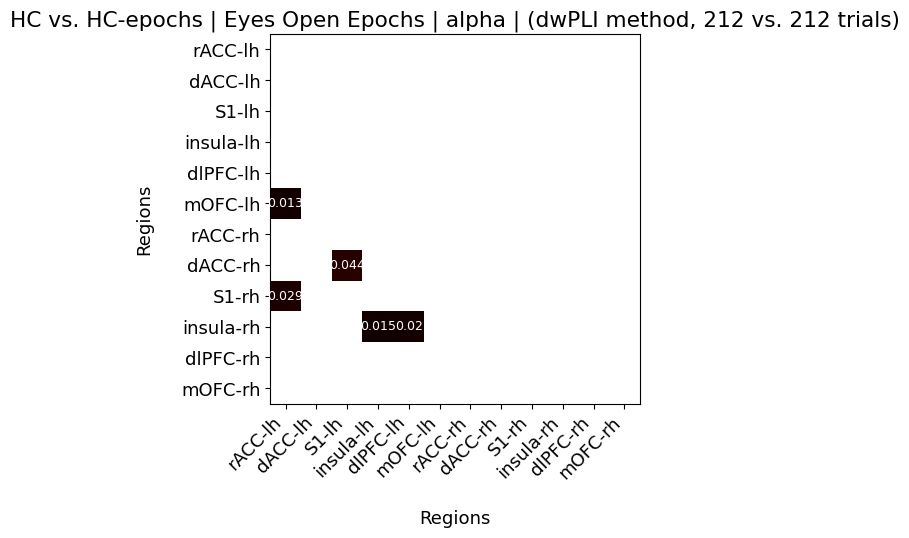

Hand 256 mN - Eyes Open Epochs - Healthy Control vs. Healthy Control Resting Epochs - wpli2_debiased - beta
Top 3 Connections in Healthy Control group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| mOFC-lh <-> dACC-lh |   4/19    |     0.239     |
| mOFC-lh <-> rACC-lh |   3/19    |     0.33      |
| dlPFC-rh <-> S1-rh  |   3/19    |     0.311     |
+---------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control Resting Epochs group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  dlPFC-rh <-> S1-lh   |   3/19    |     0.217     |
| dlPFC-rh <-> rACC-rh  |   3/19    |     0.181     |
| insula-rh <-> dACC-lh |   3/19    |     0.217     |
+-----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by Regio

<Figure size 640x480 with 0 Axes>

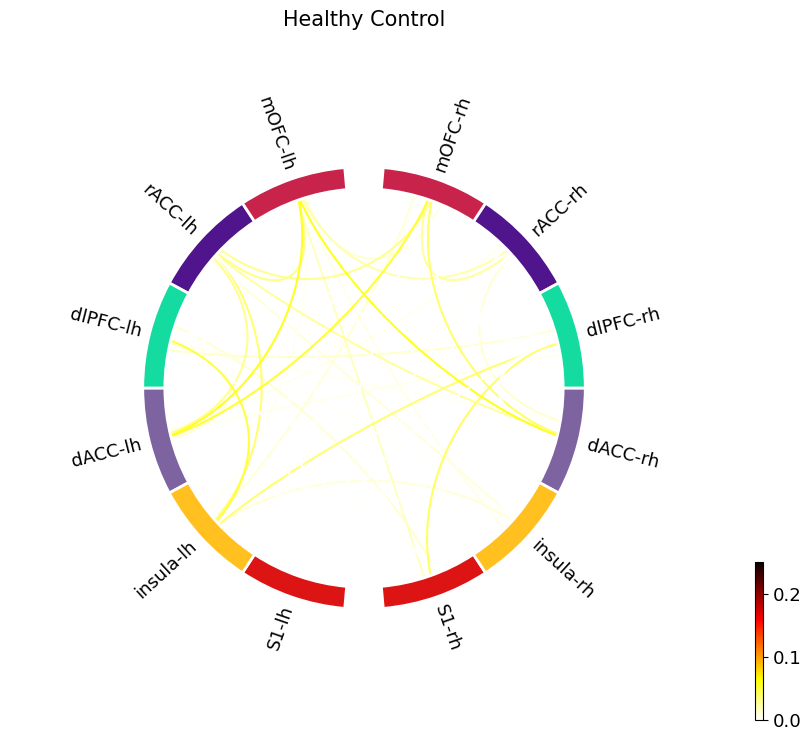

<Figure size 640x480 with 0 Axes>

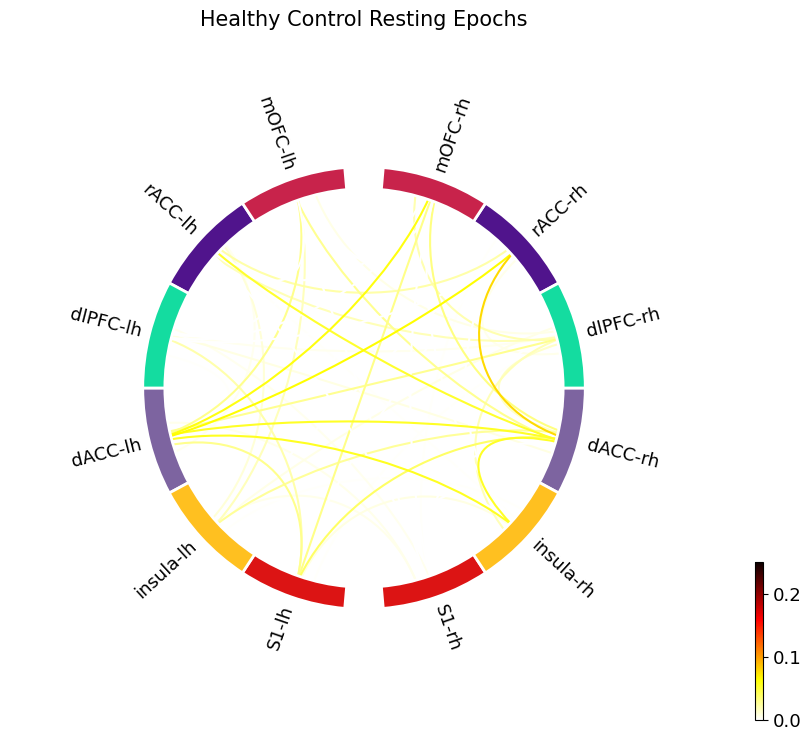

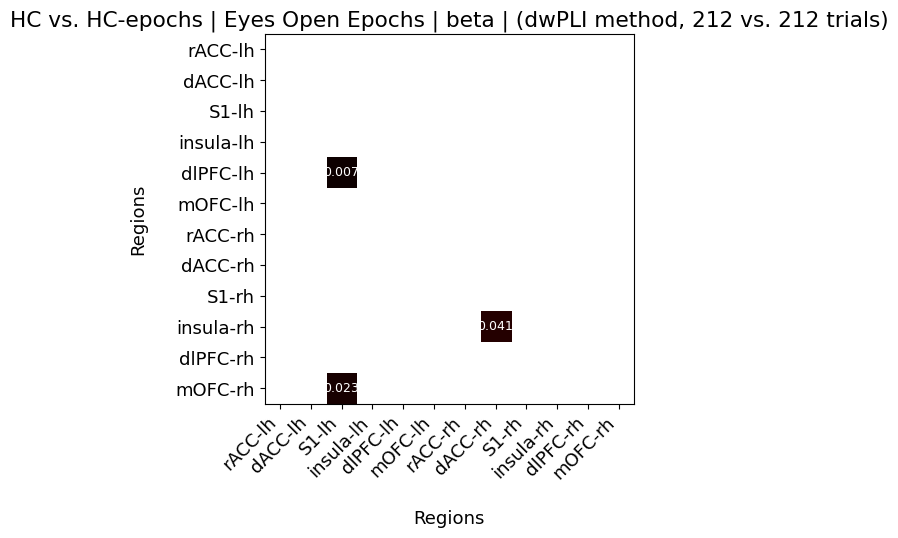

Hand 256 mN - Eyes Open Epochs - Healthy Control vs. Healthy Control Resting Epochs - wpli2_debiased - low-gamma
Top 3 Connections in Healthy Control group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
|  S1-rh <-> dACC-lh  |   3/19    |     0.256     |
| dACC-lh <-> rACC-lh |   3/19    |     0.167     |
| S1-rh <-> insula-lh |   2/19    |     0.158     |
+---------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control Resting Epochs group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| dlPFC-rh <-> rACC-rh  |   3/19    |     0.228     |
|  dACC-rh <-> rACC-rh  |   3/19    |     0.156     |
| rACC-rh <-> insula-lh |   3/19    |     0.206     |
+-----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by 

<Figure size 640x480 with 0 Axes>

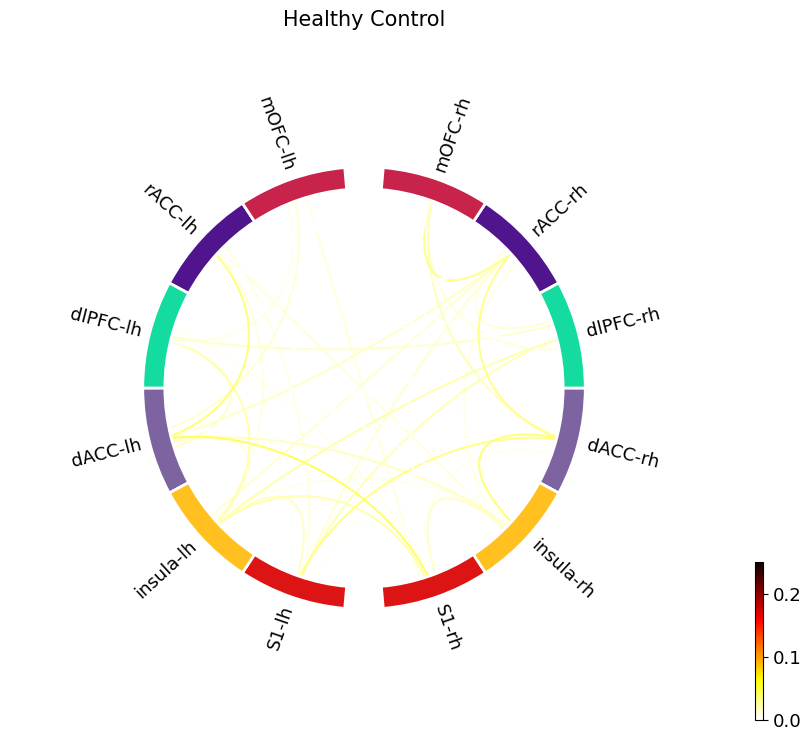

<Figure size 640x480 with 0 Axes>

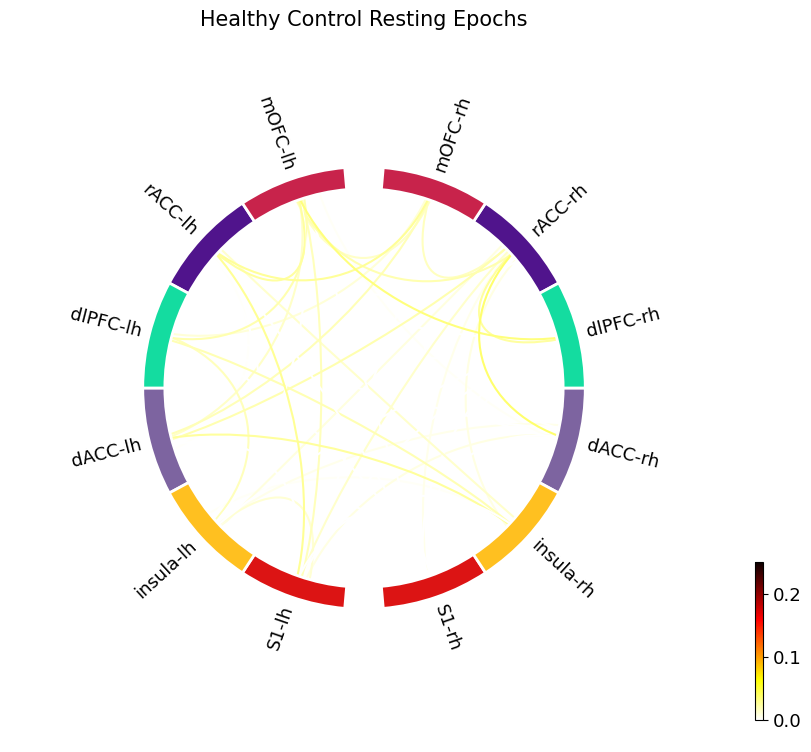

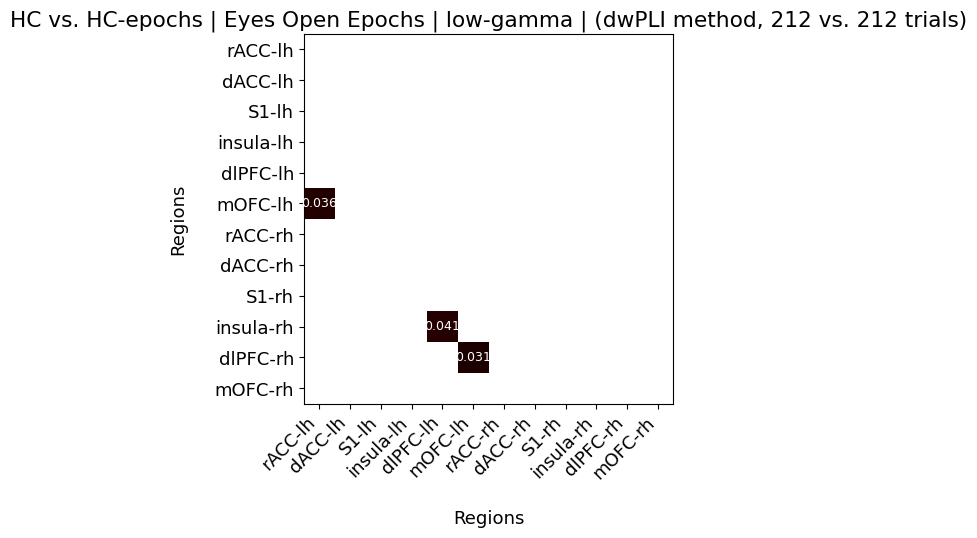

Hand 256 mN - Eyes Open Epochs - Healthy Control vs. Healthy Control Resting Epochs - wpli2_debiased - high-gamma
Top 3 Connections in Healthy Control group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| dlPFC-lh <-> rACC-lh |   3/19    |     0.194     |
| insula-lh <-> S1-lh  |   3/19    |     0.134     |
|  S1-rh <-> dlPFC-lh  |   3/19    |     0.142     |
+----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control Resting Epochs group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| mOFC-rh <-> dlPFC-lh |   4/19    |     0.212     |
| mOFC-lh <-> dlPFC-lh |   3/19    |     0.208     |
|  S1-lh <-> dACC-lh   |   3/19    |     0.24      |
+----------------------+-----------+---------------+ 

(19, 12, 12)

Betweenness Centrality by

<Figure size 640x480 with 0 Axes>

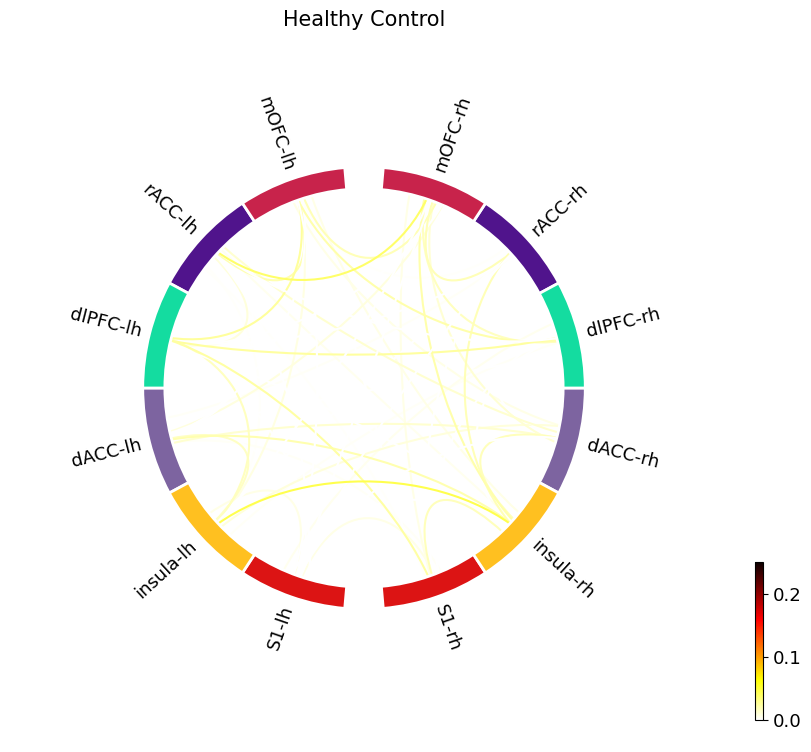

<Figure size 640x480 with 0 Axes>

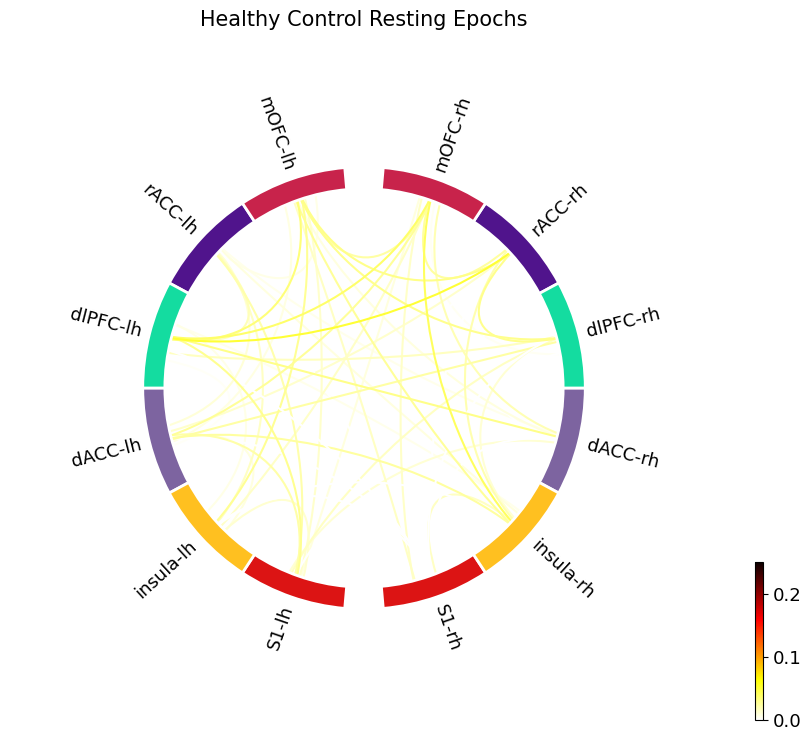

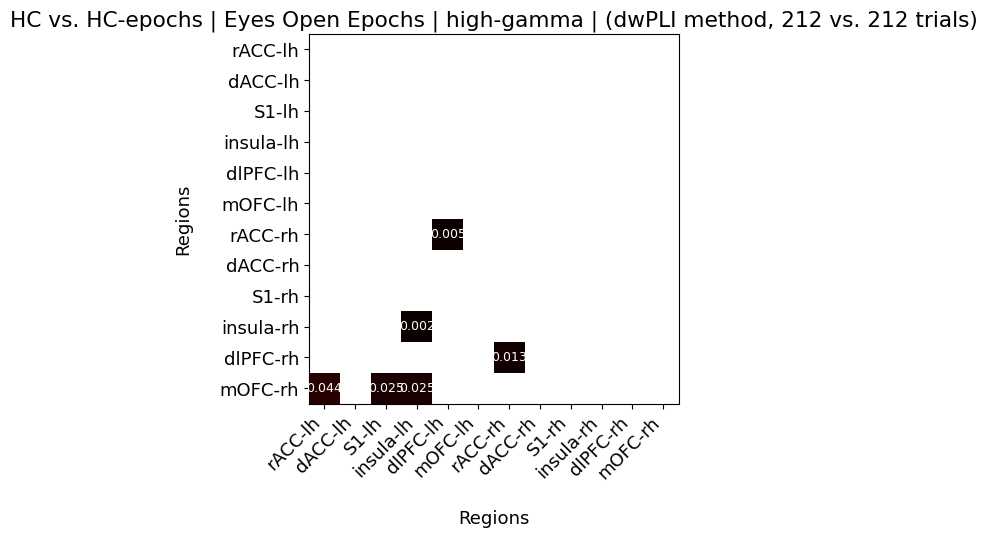

In [26]:
# Healthy Control vs. Healthy Control  Epochs from Resting
these_group_names = ["Healthy Control", "Healthy Control Resting Epochs", "Mann_Whitney_U_test"]
these_group_cons = [group_con_HC, group_con_HC_epochs]
these_sub_cons = [sub_con_HC, sub_con_HC_epochs]
these_sub_ids = [sub_ids_HC, sub_ids_HC]
condition_HC =  'Hand 256 mN'
condition_HC_epochs = 'Eyes Open Epochs'
method = 'wpli2_debiased'

# Make a directory for the stats
stats_save_path = save_path / f"HC_vs_HC-epochs"
os.makedirs(stats_save_path, exist_ok=True)

for band in band_names:
    ## Save all output to a text file
    # Backup original stdout  
    orig_stdout = sys.stdout  
    if method=="wpli2_debiased":
        f = open(stats_save_path / f'{condition_HC}_{condition_HC_epochs}_{band}_dwPLI.txt', 'w')  
    else:
        f = open(stats_save_path / f'{condition_HC}_{condition_HC_epochs}_{band}_{method}.txt', 'w')
                
    # Set stdout to the file object  
    if save_txt:
        sys.stdout = f  
            
    # Select groups for mann-whitney
    print(f"{condition_HC} - {condition_HC_epochs} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
        
    # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
    top_3_info=None
    group_con=None
    for group_con,group_name,sub_con in zip(these_group_cons, these_group_names, these_sub_cons):
        table_data = []  
        if group_con == these_group_cons[0]:
            condition = condition_HC
        else:
            condition = condition_HC_epochs
        top_3_info = group_con[condition][method][band]["top 3"] 
        print(f"Top 3 Connections in {group_name} group")
        for i in range(3):  
            connection = top_3_info["connections"][i]  
            frequency = top_3_info["frequency"][i]  
            mean_strength = top_3_info["mean strength"][i]
            table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", f"{frequency}/{len(sub_con)}", mean_strength]) 
                
        # Define table headers  
        headers = ['Connection', 'Frequency', 'Mean Strength']  
                
        # Print the table  
        print(tabulate(table_data, headers, tablefmt='pretty'),'\n')  

    group1_stack = these_group_cons[0][condition_HC][method][band]["data"]
    print(group1_stack.shape)
    group2_stack = these_group_cons[1][condition_HC_epochs][method][band]["data"]

    nepochs_1 = these_group_cons[0][condition_HC]['num_epochs']
    nepochs_2 = these_group_cons[1][condition_HC_epochs]['num_epochs']
            
    # Compute the Mann-Whitney U test
    p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test_epochs(
        group1_stack,
        group2_stack,
        roi_acronyms=roi_acronyms,
        sub_ids1=these_sub_ids[0],
        sub_ids2=these_sub_ids[1],
        condition_group1=condition_HC,
        condition_group2=condition_HC_epochs,
        bilateral_pain_ids=bilateral_pain_ids,
        round_neg_vals=round_neg_vals,
        method=method)

    vmin = None
    vmax = None
            
    # Plotting
    # Gather the information for plotting
    plot_kwargs= dict(
        method=method,
        band=band, 
        roi_names=roi_names,
        roi_acronyms=roi_acronyms,
        condition=condition,
        vmin=vmin,
        vmax=vmax,
        group_names=these_group_names,
        nepochs=[nepochs_1, nepochs_2],
        titles=[these_group_names[0], 
                these_group_names[1],
                "HC vs. HC-epochs",],
        save_names=["Mann_Whitney_U_test",
                    these_group_names[0], 
                    these_group_names[1],
                    ],
            save_path=stats_save_path,
        )

    # Compute the centrality and test
    fc.compute_centrality_and_test(group1_stack,
                                    group2_stack, 
                                    roi_acronyms=roi_acronyms,
                                    sub_ids1=these_sub_ids[0],
                                    sub_ids2=these_sub_ids[1],
                                    bilateral_pain_ids=bilateral_pain_ids,
                                    condition=condition,
                                    )     
        
    print(f"\nNum epochs: {nepochs_1} vs. {nepochs_2}")               
    fc.plot_connectivity_and_stats(means_1=means_1,
                                means_2=means_2,
                                sem_1=sem_1,
                                sem_2=sem_2,
                                p_values=p_values,
                                **plot_kwargs,
                                save_fig=True,
                                highlight_pvals=highlight_pvals,
                                min_fc_val=None,
                                set_title=set_title,
                                show_fc_vals=show_fc_vals,
                                round_neg_vals=round_neg_vals,
    )
    
        
    # Reset the standard output to its original value  
    sys.stdout = orig_stdout  
            
    f.close()  

Hand 256 mN - Eyes Open Epochs - Widespread Pain vs. Widespread Pain Resting Epochs - wpli2_debiased - theta
Top 3 Connections in Widespread Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-rh <-> rACC-lh |   3/12    |     0.285     |
| dlPFC-rh <-> dACC-lh  |   2/12    |     0.266     |
|   rACC-rh <-> S1-lh   |   2/12    |     0.375     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Widespread Pain Resting Epochs group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|    S1-rh <-> S1-lh    |   3/12    |     0.725     |
| insula-rh <-> rACC-rh |   3/12    |     0.444     |
|  insula-lh <-> S1-lh  |   2/12    |     0.395     |
+-----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Cent

<Figure size 640x480 with 0 Axes>

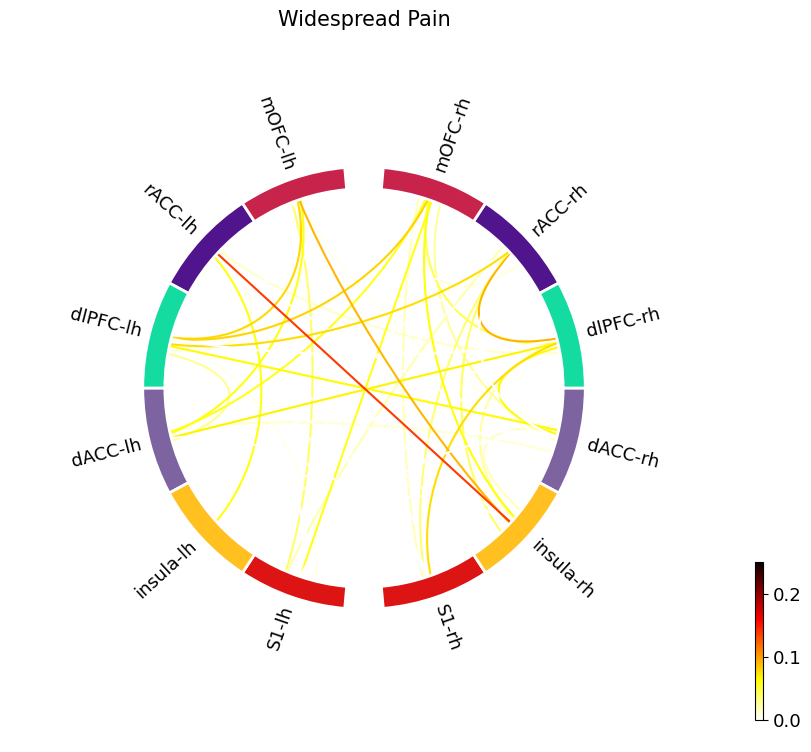

<Figure size 640x480 with 0 Axes>

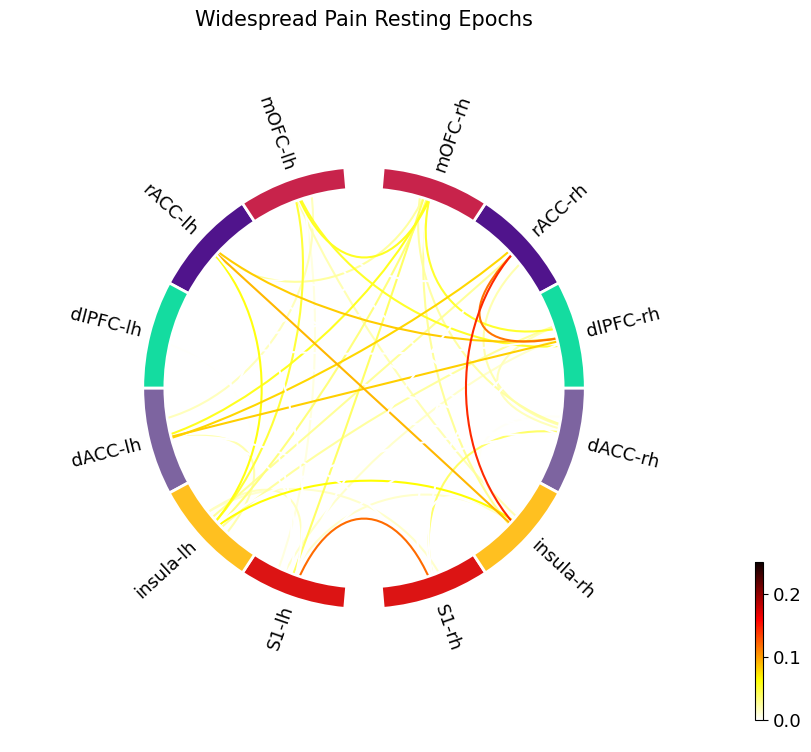

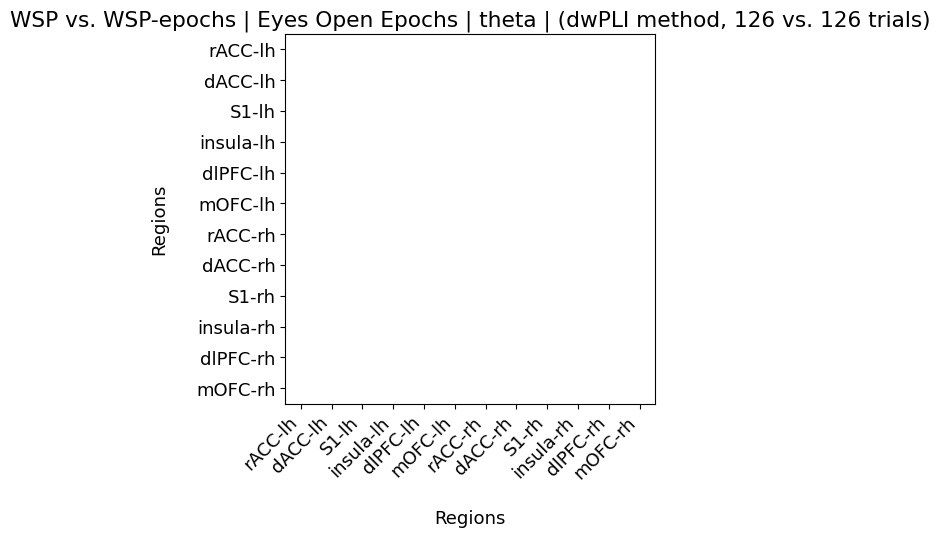

Hand 256 mN - Eyes Open Epochs - Widespread Pain vs. Widespread Pain Resting Epochs - wpli2_debiased - alpha
Top 3 Connections in Widespread Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  dlPFC-rh <-> S1-rh   |   3/12    |     0.516     |
|  mOFC-rh <-> mOFC-lh  |   2/12    |     0.52      |
| mOFC-lh <-> insula-lh |   2/12    |     0.28      |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Widespread Pain Resting Epochs group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| dlPFC-lh <-> rACC-lh |   2/12    |     0.253     |
| dACC-rh <-> dACC-lh  |   2/12    |     0.445     |
|  dlPFC-rh <-> S1-lh  |   2/12    |     0.538     |
+----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality 

<Figure size 640x480 with 0 Axes>

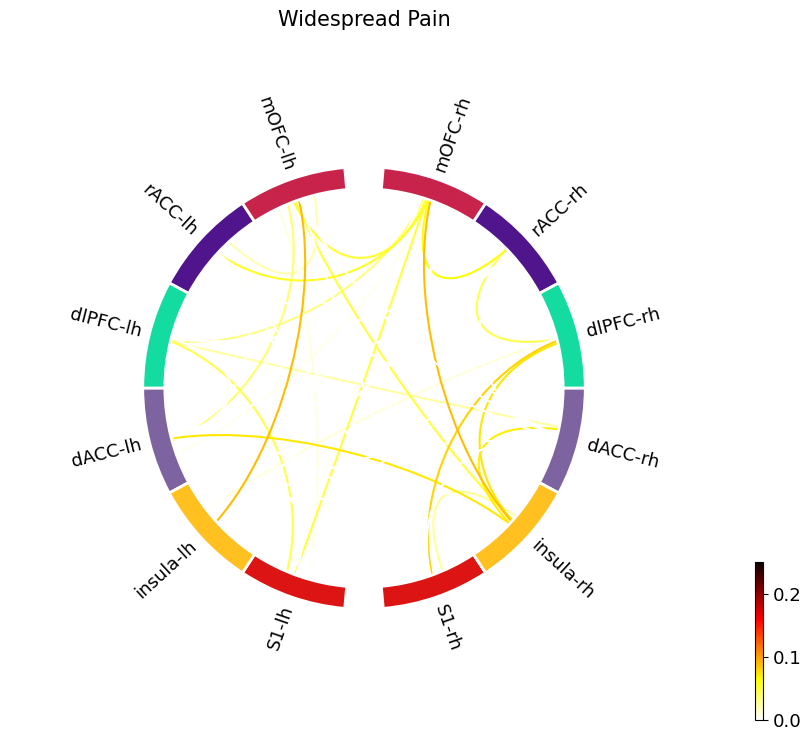

<Figure size 640x480 with 0 Axes>

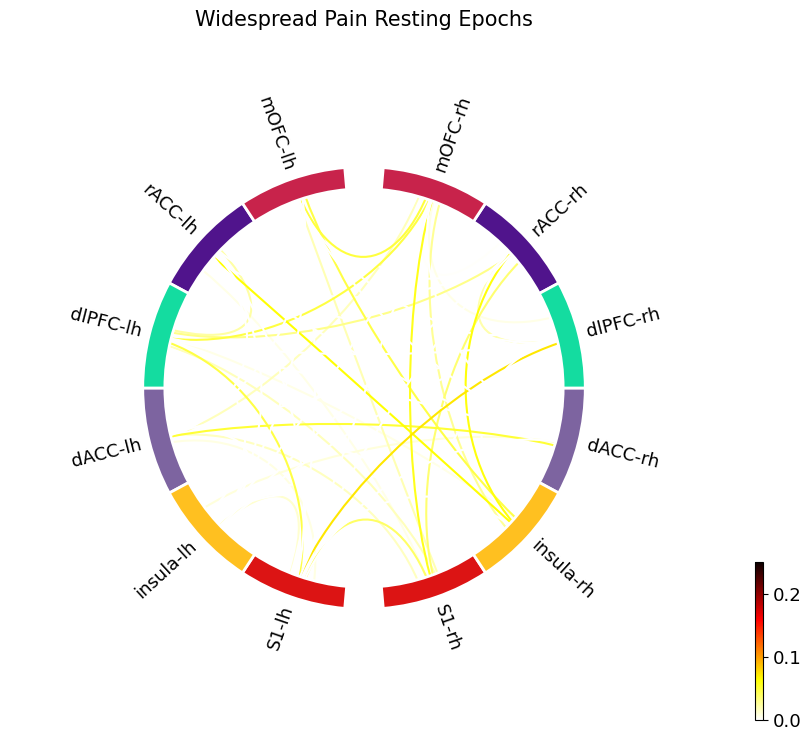

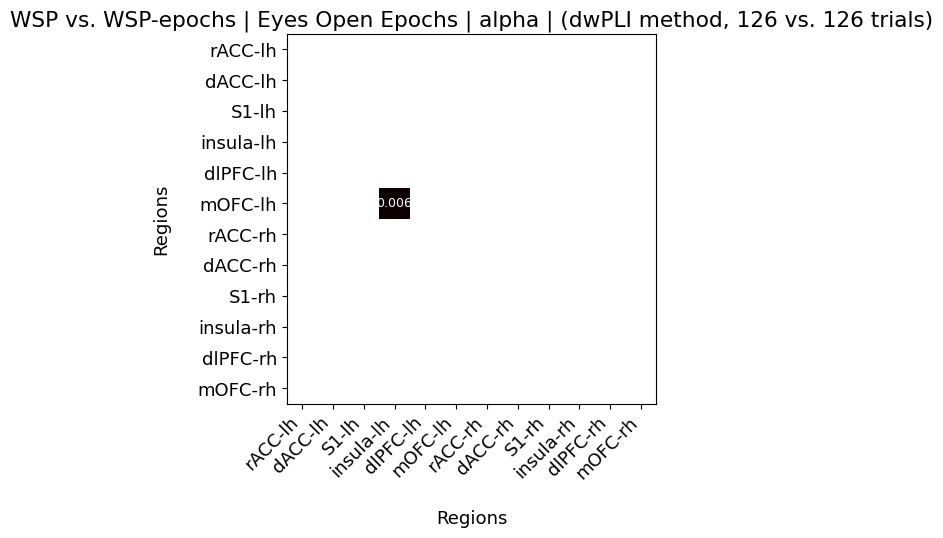

Hand 256 mN - Eyes Open Epochs - Widespread Pain vs. Widespread Pain Resting Epochs - wpli2_debiased - beta
Top 3 Connections in Widespread Pain group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| insula-rh <-> S1-lh |   2/12    |     0.154     |
|  S1-lh <-> rACC-lh  |   2/12    |     0.278     |
|  rACC-rh <-> S1-lh  |   2/12    |     0.202     |
+---------------------+-----------+---------------+ 

Top 3 Connections in Widespread Pain Resting Epochs group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  mOFC-rh <-> rACC-lh  |   2/12    |     0.242     |
|  insula-lh <-> S1-lh  |   2/12    |     0.333     |
| rACC-rh <-> insula-lh |   2/12    |     0.235     |
+-----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by Regio

<Figure size 640x480 with 0 Axes>

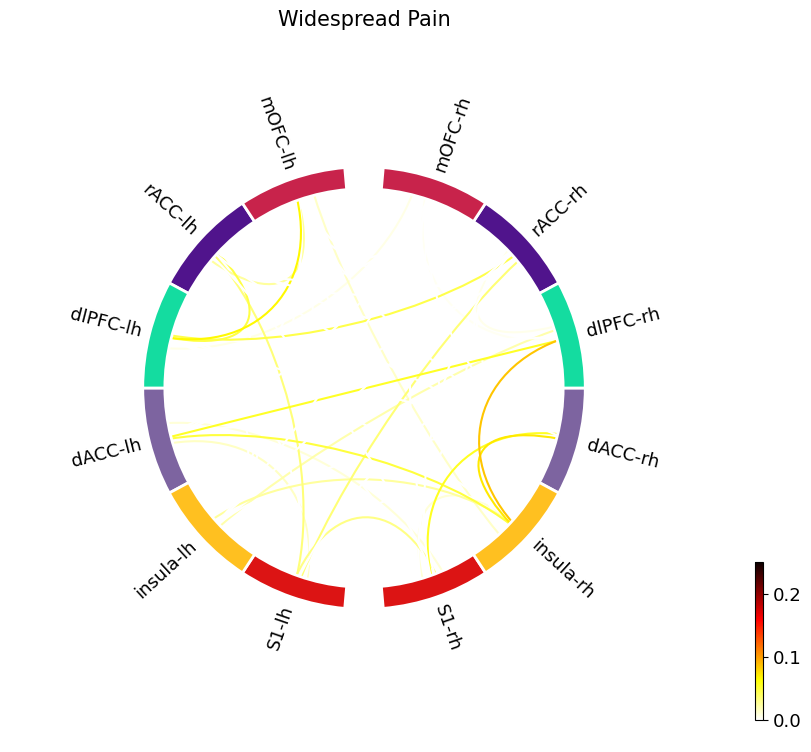

<Figure size 640x480 with 0 Axes>

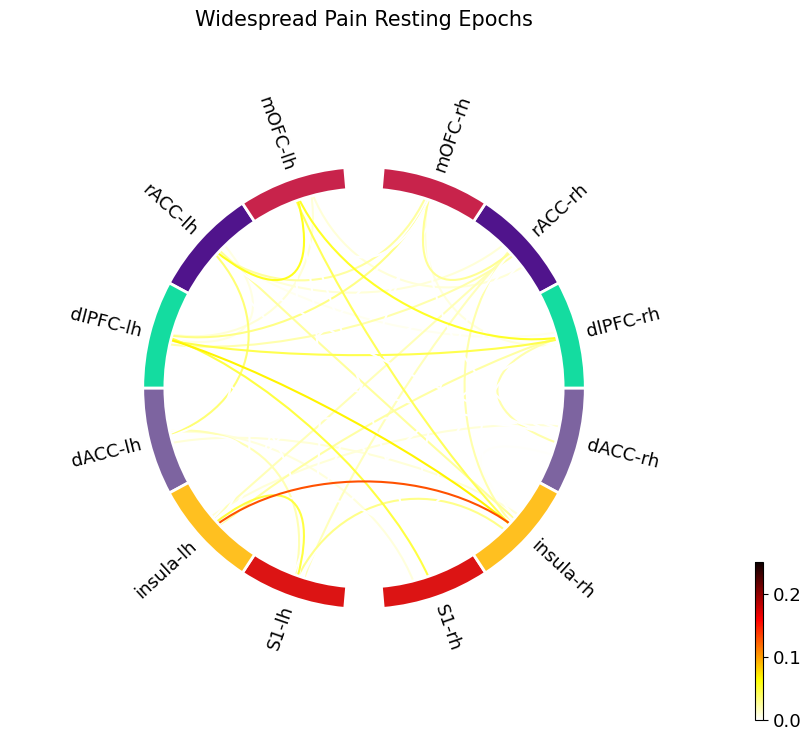

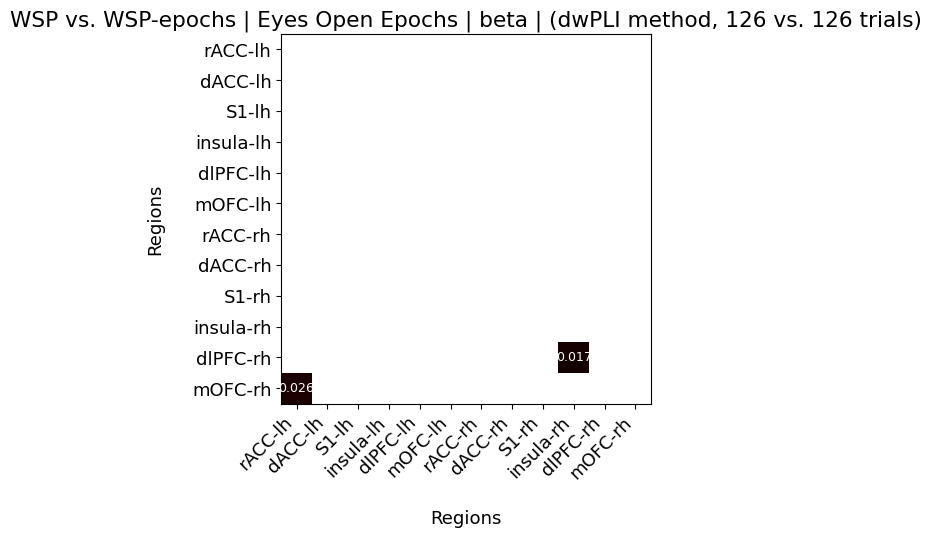

Hand 256 mN - Eyes Open Epochs - Widespread Pain vs. Widespread Pain Resting Epochs - wpli2_debiased - low-gamma
Top 3 Connections in Widespread Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| mOFC-rh <-> rACC-lh  |   4/12    |     0.166     |
|  dACC-rh <-> S1-lh   |   2/12    |     0.136     |
| dlPFC-lh <-> rACC-lh |   2/12    |     0.18      |
+----------------------+-----------+---------------+ 

Top 3 Connections in Widespread Pain Resting Epochs group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
|  rACC-rh <-> S1-lh   |   3/12    |     0.283     |
| rACC-rh <-> rACC-lh  |   2/12    |     0.212     |
| dlPFC-lh <-> rACC-lh |   2/12    |     0.25      |
+----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by 

<Figure size 640x480 with 0 Axes>

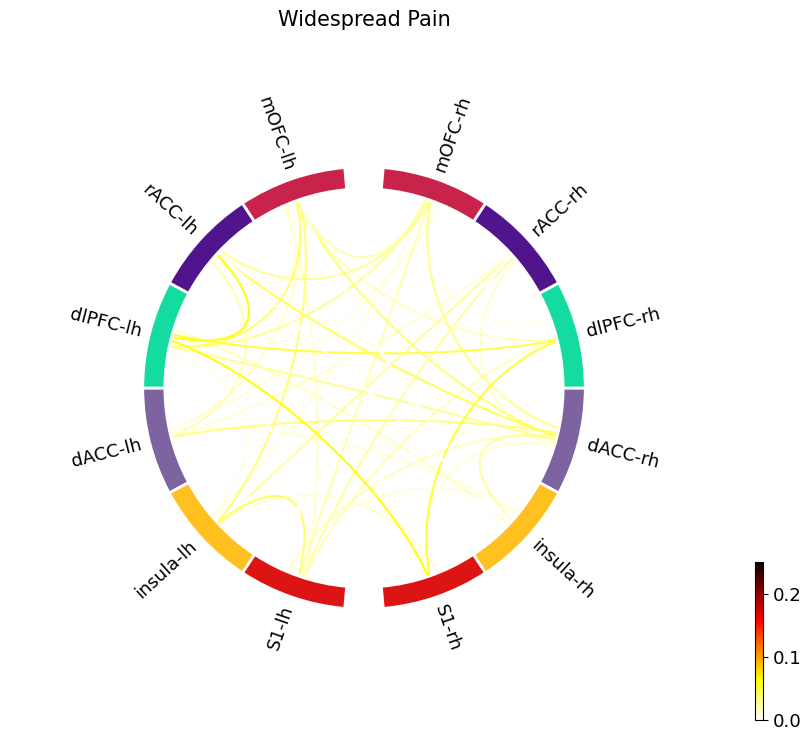

<Figure size 640x480 with 0 Axes>

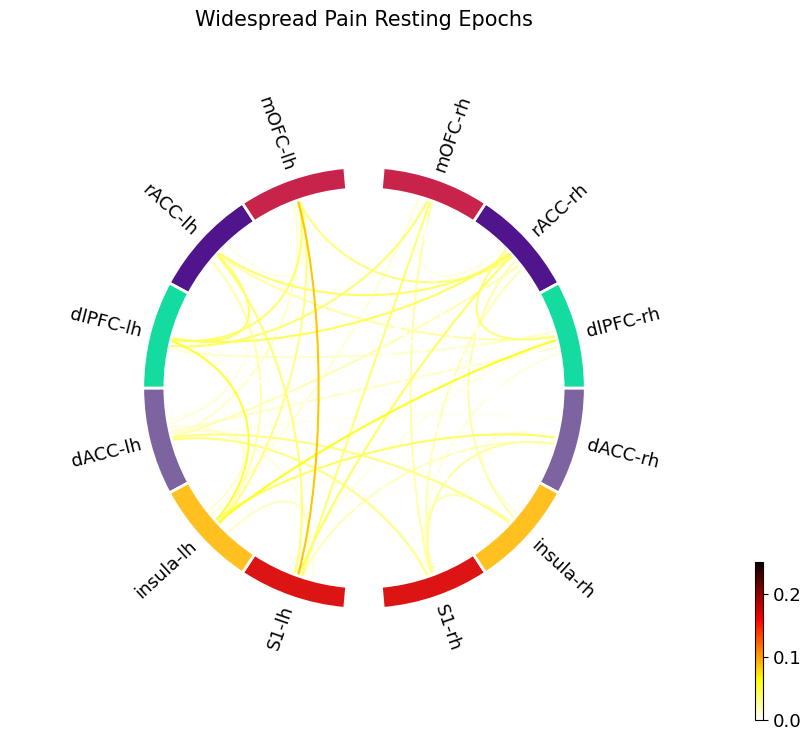

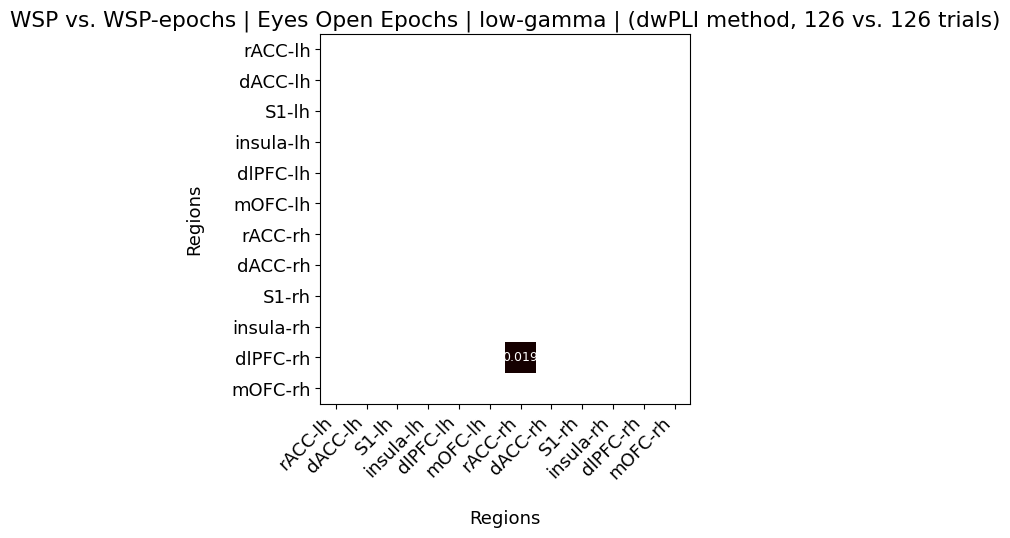

Hand 256 mN - Eyes Open Epochs - Widespread Pain vs. Widespread Pain Resting Epochs - wpli2_debiased - high-gamma
Top 3 Connections in Widespread Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| dlPFC-rh <-> dACC-lh  |   2/12    |     0.222     |
| dlPFC-rh <-> dACC-rh  |   2/12    |     0.146     |
| dACC-rh <-> insula-lh |   2/12    |     0.152     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Widespread Pain Resting Epochs group
+-------------------------+-----------+---------------+
|       Connection        | Frequency | Mean Strength |
+-------------------------+-----------+---------------+
|  insula-lh <-> dACC-lh  |   2/12    |     0.208     |
|   rACC-rh <-> mOFC-lh   |   2/12    |     0.217     |
| insula-rh <-> insula-lh |   2/12    |     0.175     |
+-------------------------+-----------+---------------+ 

(12, 12, 12

<Figure size 640x480 with 0 Axes>

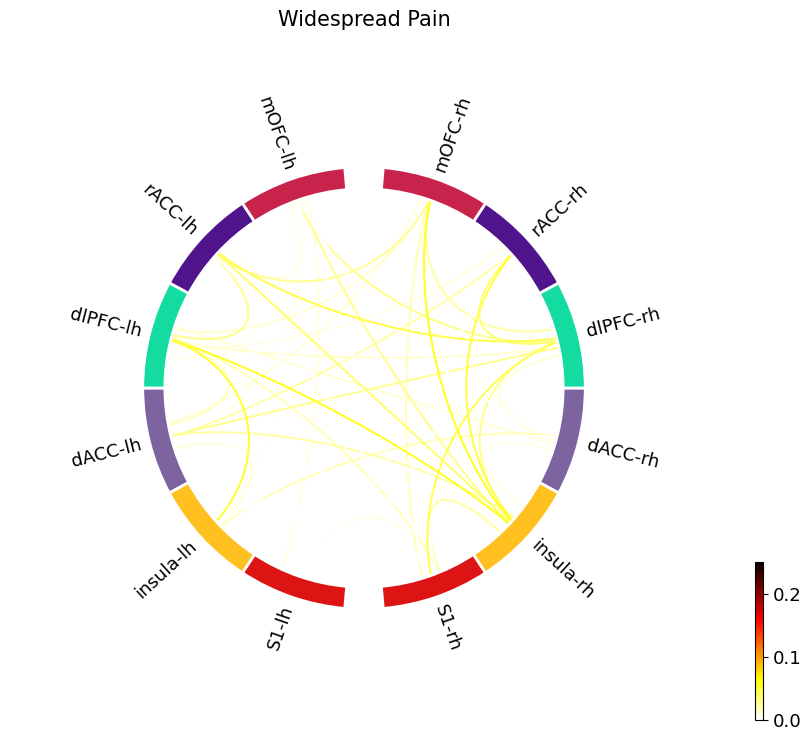

<Figure size 640x480 with 0 Axes>

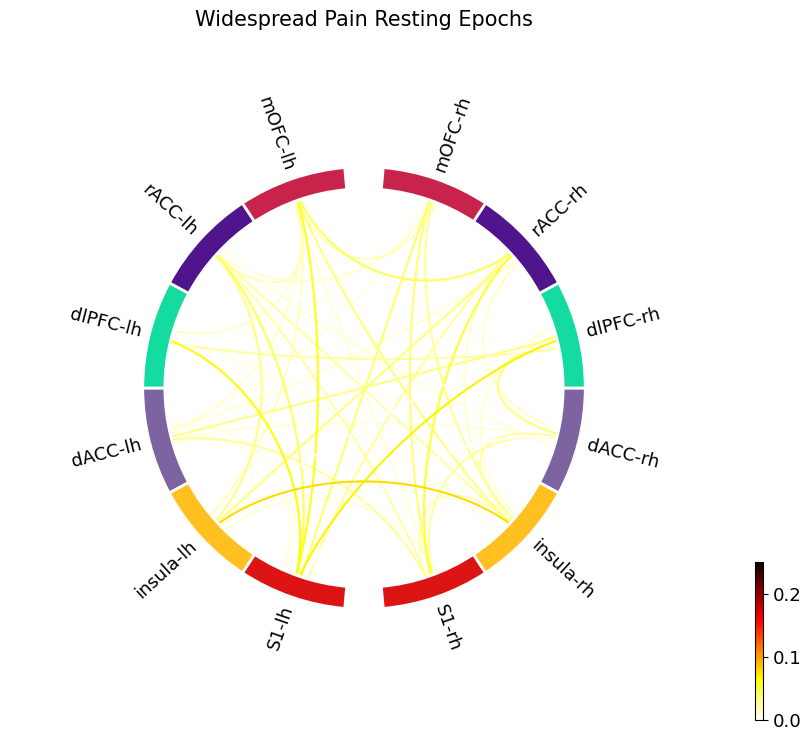

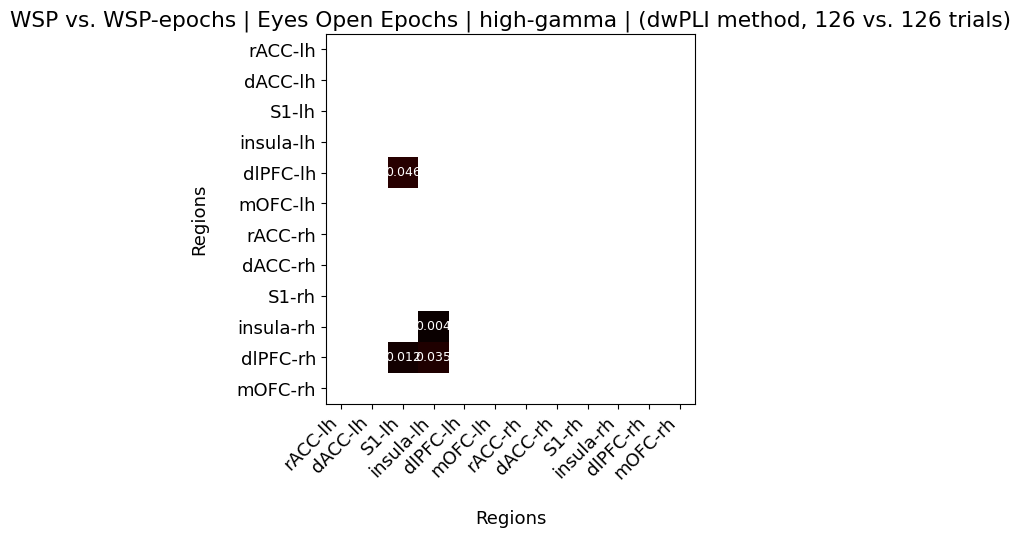

In [27]:
# Widespread Pain vs. Widespread Pain Epochs from Resting
these_group_names = ["Widespread Pain", "Widespread Pain Resting Epochs", "Mann_Whitney_U_test"]
these_group_cons = [group_con_WSP, group_con_WSP_epochs]
these_sub_cons = [sub_con_WSP, sub_con_WSP_epochs]
these_sub_ids = [sub_ids_WSP, sub_ids_WSP]
condition_WSP =  'Hand 256 mN'
condition_WSP_epochs = 'Eyes Open Epochs'
method = 'wpli2_debiased'

# Make a directory for the stats
stats_save_path = save_path / f"WSP_vs_WSP-epochs"
os.makedirs(stats_save_path, exist_ok=True)

for band in band_names:
    ## Save all output to a text file
    # Backup original stdout  
    orig_stdout = sys.stdout  
    if method=="wpli2_debiased":
        f = open(stats_save_path / f'{condition_WSP}_{condition_WSP_epochs}_{band}_dwPLI.txt', 'w')  
    else:
        f = open(stats_save_path / f'{condition_WSP}_{condition_WSP_epochs}_{band}_{method}.txt', 'w')
                
    # Set stdout to the file object  
    if save_txt:
        sys.stdout = f  
            
    # Select groups for mann-whitney
    print(f"{condition_WSP} - {condition_WSP_epochs} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
        
    # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
    top_3_info=None
    group_con=None
    for group_con,group_name,sub_con in zip(these_group_cons, these_group_names, these_sub_cons):
        table_data = []  
        if group_con == these_group_cons[0]:
            condition = condition_WSP
        else:
            condition = condition_WSP_epochs
        top_3_info = group_con[condition][method][band]["top 3"] 
        print(f"Top 3 Connections in {group_name} group")
        for i in range(3):  
            connection = top_3_info["connections"][i]  
            frequency = top_3_info["frequency"][i]  
            mean_strength = top_3_info["mean strength"][i]
            table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", f"{frequency}/{len(sub_con)}", mean_strength]) 
                
        # Define table headers  
        headers = ['Connection', 'Frequency', 'Mean Strength']  
                
        # Print the table  
        print(tabulate(table_data, headers, tablefmt='pretty'),'\n')  

    group1_stack = these_group_cons[0][condition_WSP][method][band]["data"]
    print(group1_stack.shape)
    group2_stack = these_group_cons[1][condition_WSP_epochs][method][band]["data"]

    nepochs_1 = these_group_cons[0][condition_WSP]['num_epochs']
    nepochs_2 = these_group_cons[1][condition_WSP_epochs]['num_epochs']
            
    # Compute the Mann-Whitney U test
    p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test_epochs(
        group1_stack,
        group2_stack,
        roi_acronyms=roi_acronyms,
        sub_ids1=these_sub_ids[0],
        sub_ids2=these_sub_ids[1],
        condition_group1=condition_WSP,
        condition_group2=condition_WSP_epochs,
        bilateral_pain_ids=bilateral_pain_ids,
        round_neg_vals=round_neg_vals,
        method=method)

    vmin = None
    vmax = None
            
    # Plotting
    # Gather the information for plotting
    plot_kwargs= dict(
        method=method,
        band=band, 
        roi_names=roi_names,
        roi_acronyms=roi_acronyms,
        condition=condition,
        vmin=vmin,
        vmax=vmax,
        group_names=these_group_names,
        nepochs=[nepochs_1, nepochs_2],
        titles=[these_group_names[0], 
                these_group_names[1],
                "WSP vs. WSP-epochs",],
        save_names=["Mann_Whitney_U_test",
                    these_group_names[0], 
                    these_group_names[1],
                    ],
            save_path=stats_save_path,
        )
            
    # Compute the centrality and test
    fc.compute_centrality_and_test(group1_stack,
                                    group2_stack, 
                                    roi_acronyms=roi_acronyms,
                                    sub_ids1=these_sub_ids[0],
                                    sub_ids2=these_sub_ids[1],
                                    bilateral_pain_ids=bilateral_pain_ids,
                                    condition=condition,
                                    )
            
    print(f"\nNum epochs: {nepochs_1} vs. {nepochs_2}")               
    fc.plot_connectivity_and_stats(means_1=means_1,
                                means_2=means_2,
                                sem_1=sem_1,
                                sem_2=sem_2,
                                p_values=p_values,
                                **plot_kwargs,
                                save_fig=True,
                                highlight_pvals=highlight_pvals,
                                min_fc_val=None,
                                set_title=set_title,
                                show_fc_vals=show_fc_vals,
                                round_neg_vals=round_neg_vals,
    )
    
        
    # Reset the standard output to its original value  
    sys.stdout = orig_stdout  
            
    f.close()  

Hand 256 mN - Eyes Open Epochs - Localized Pain vs. Localized Pain Resting Epochs - wpli2_debiased - theta
Top 3 Connections in Localized Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| mOFC-rh <-> rACC-rh  |   4/12    |     0.547     |
| dACC-rh <-> dlPFC-lh |   3/12    |     0.572     |
| dACC-rh <-> dACC-lh  |   3/12    |     0.383     |
+----------------------+-----------+---------------+ 

Top 3 Connections in Localized Pain Resting Epochs group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| mOFC-rh <-> insula-rh |   2/12    |     0.338     |
| insula-rh <-> rACC-rh |   2/12    |     0.489     |
| rACC-rh <-> insula-lh |   2/12    |     0.304     |
+-----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by R

<Figure size 640x480 with 0 Axes>

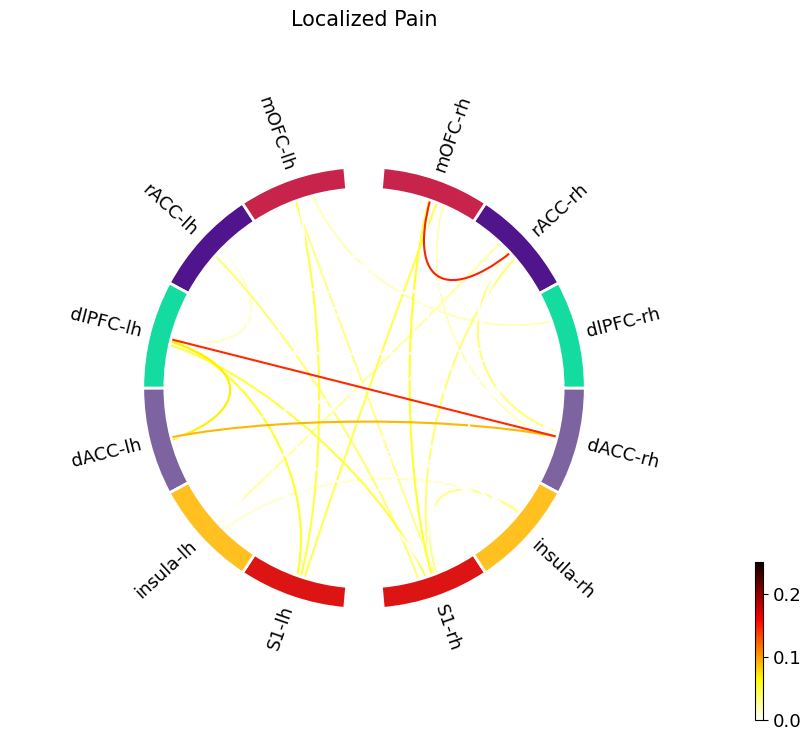

<Figure size 640x480 with 0 Axes>

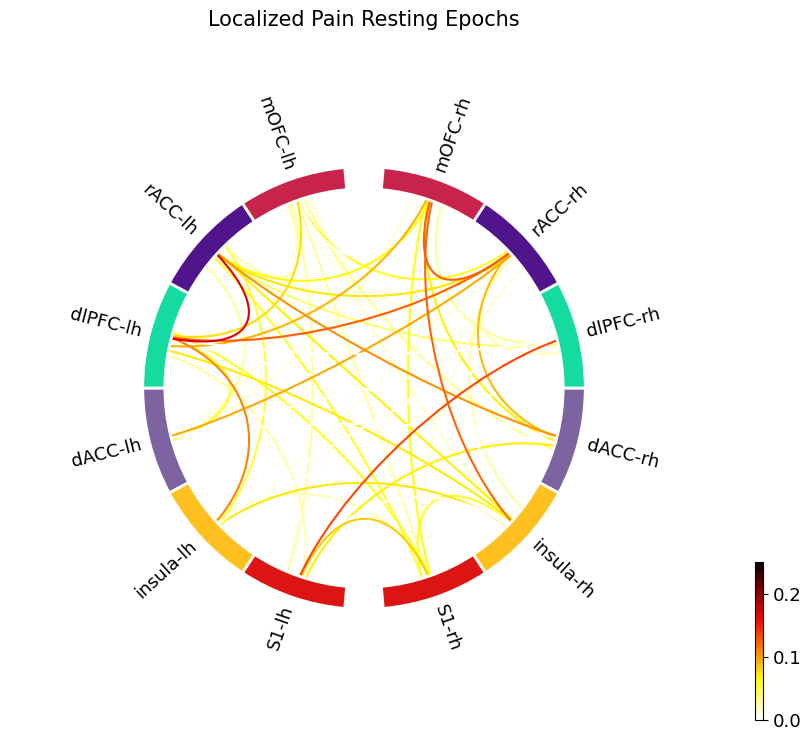

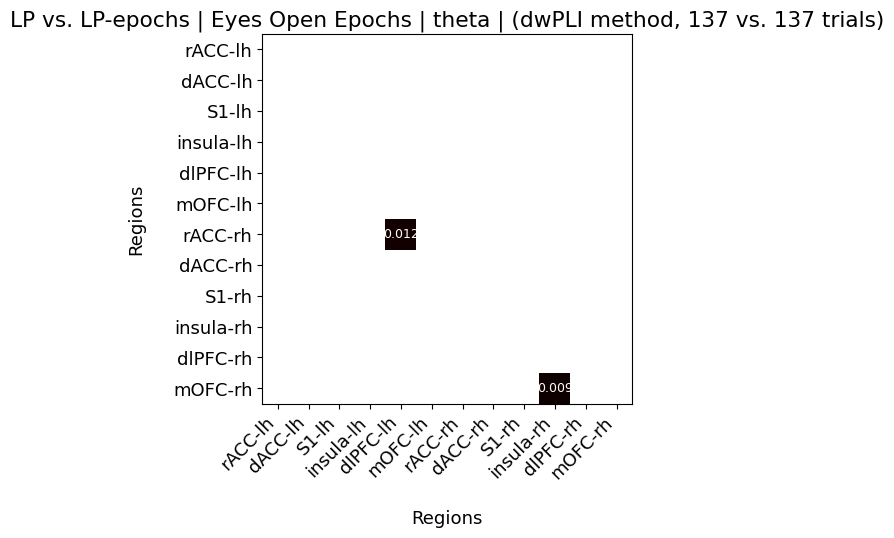

Hand 256 mN - Eyes Open Epochs - Localized Pain vs. Localized Pain Resting Epochs - wpli2_debiased - alpha
Top 3 Connections in Localized Pain group
+-------------------+-----------+---------------+
|    Connection     | Frequency | Mean Strength |
+-------------------+-----------+---------------+
| S1-rh <-> rACC-lh |   2/12    |     0.296     |
| S1-rh <-> rACC-rh |   2/12    |     0.43      |
| mOFC-rh <-> S1-rh |   2/12    |     0.349     |
+-------------------+-----------+---------------+ 

Top 3 Connections in Localized Pain Resting Epochs group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| mOFC-rh <-> dlPFC-rh |   3/12    |     0.442     |
| mOFC-rh <-> mOFC-lh  |   2/12    |     0.196     |
| dlPFC-rh <-> mOFC-lh |   2/12    |     0.29      |
+----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality by Region:
+-----------+--------

<Figure size 640x480 with 0 Axes>

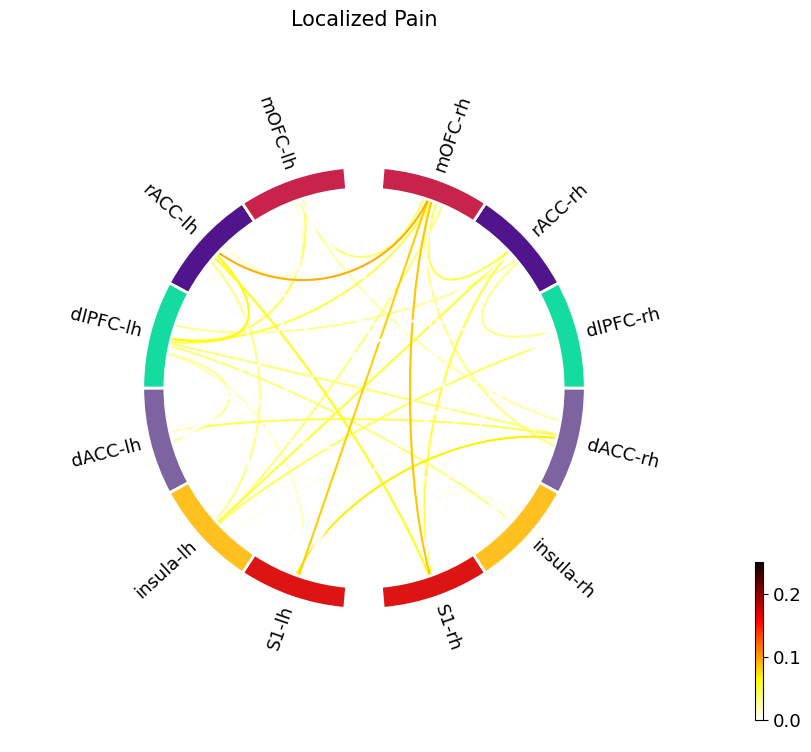

<Figure size 640x480 with 0 Axes>

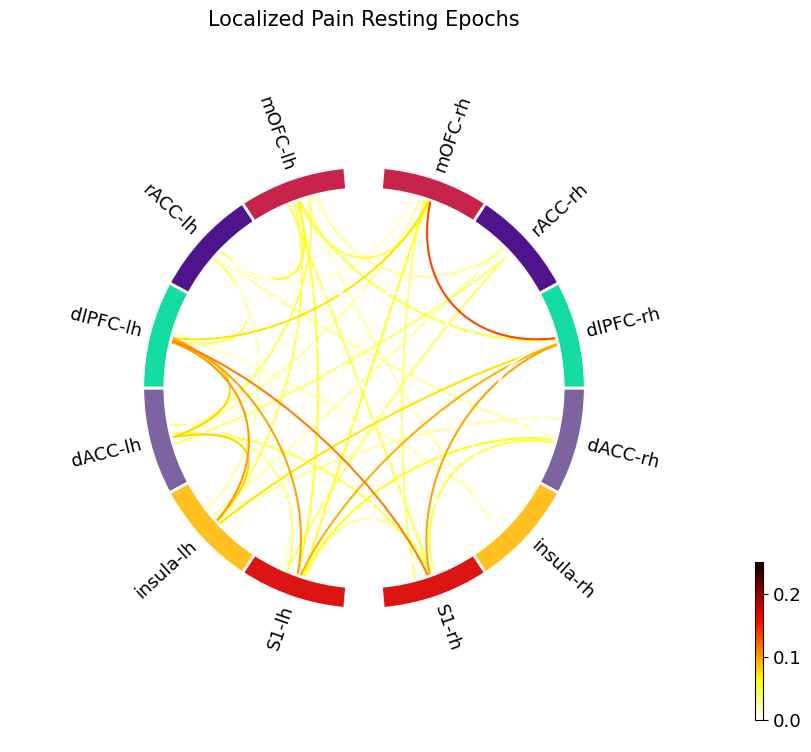

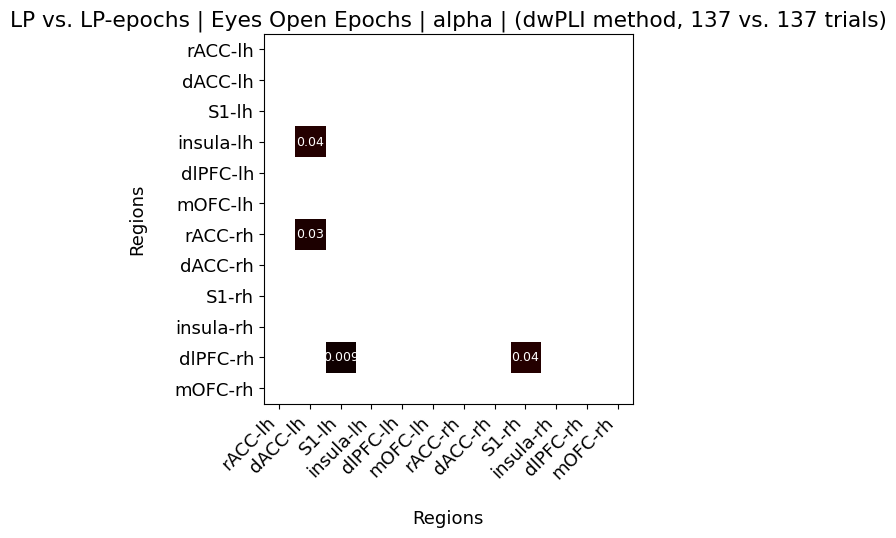

Hand 256 mN - Eyes Open Epochs - Localized Pain vs. Localized Pain Resting Epochs - wpli2_debiased - beta
Top 3 Connections in Localized Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-rh <-> dACC-lh |   3/12    |     0.198     |
| mOFC-rh <-> dlPFC-rh  |   2/12    |     0.189     |
|  rACC-rh <-> dACC-lh  |   2/12    |     0.214     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Localized Pain Resting Epochs group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
| insula-rh <-> dACC-rh  |   3/12    |     0.195     |
|  dACC-lh <-> rACC-lh   |   3/12    |     0.236     |
| dlPFC-rh <-> insula-rh |   3/12    |     0.256     |
+------------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Ce

<Figure size 640x480 with 0 Axes>

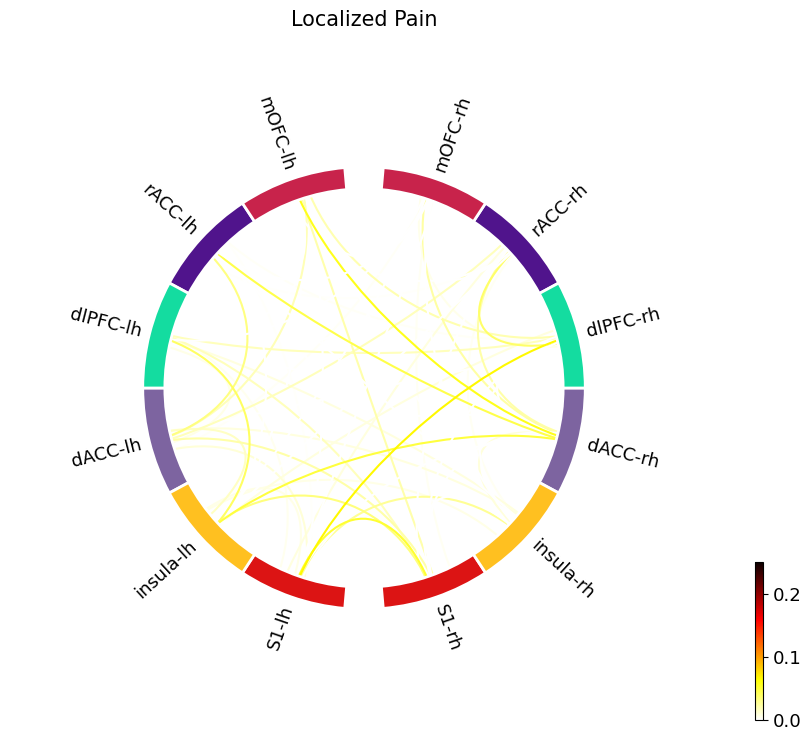

<Figure size 640x480 with 0 Axes>

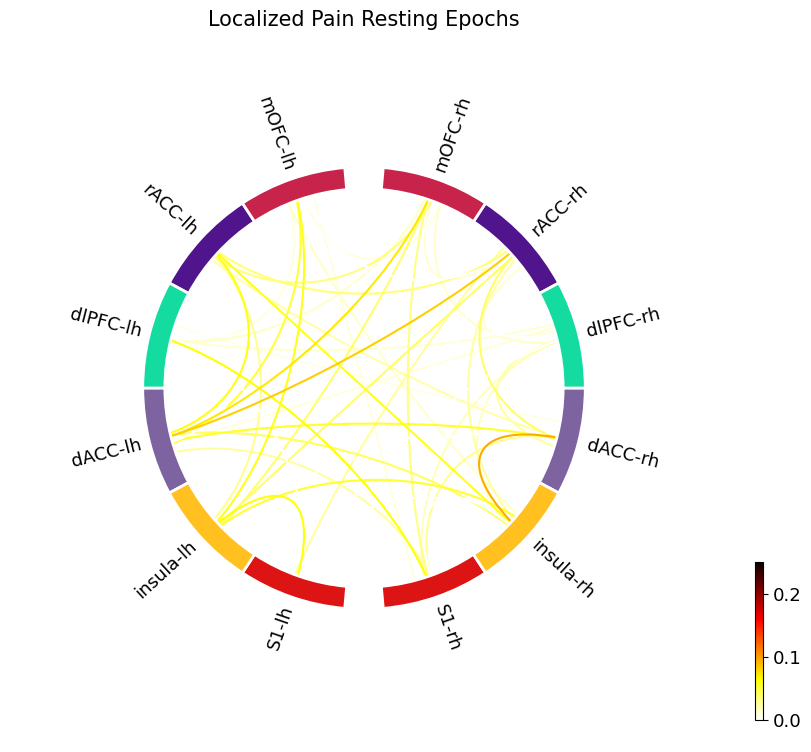

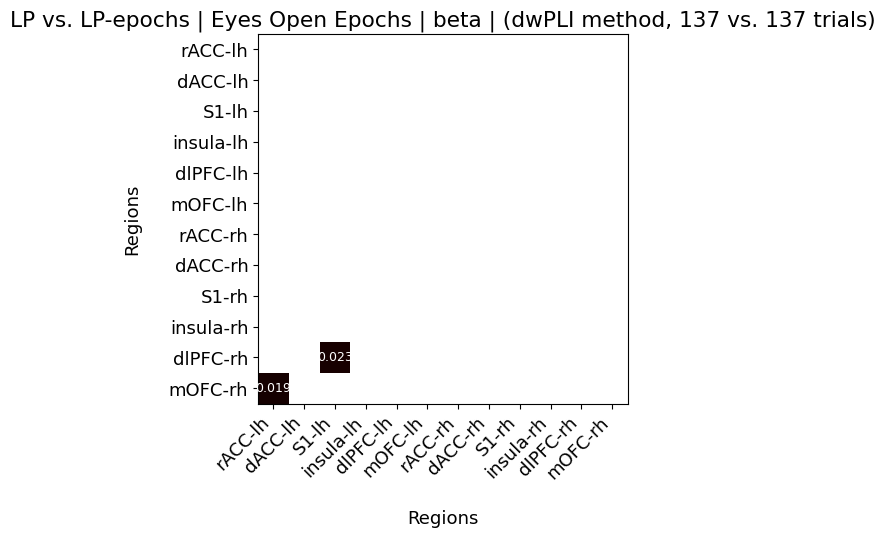

Hand 256 mN - Eyes Open Epochs - Localized Pain vs. Localized Pain Resting Epochs - wpli2_debiased - low-gamma
Top 3 Connections in Localized Pain group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
| insula-rh <-> rACC-lh  |   3/12    |     0.168     |
|  mOFC-rh <-> dACC-rh   |   2/12    |     0.158     |
| dlPFC-rh <-> insula-rh |   2/12    |     0.11      |
+------------------------+-----------+---------------+ 

Top 3 Connections in Localized Pain Resting Epochs group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
|  mOFC-lh <-> S1-lh  |   4/12    |     0.258     |
|  S1-lh <-> dACC-lh  |   3/12    |     0.15      |
| mOFC-rh <-> rACC-lh |   3/12    |     0.19      |
+---------------------+-----------+---------------+ 

(12, 12, 12)

Betweenness Centrality 

<Figure size 640x480 with 0 Axes>

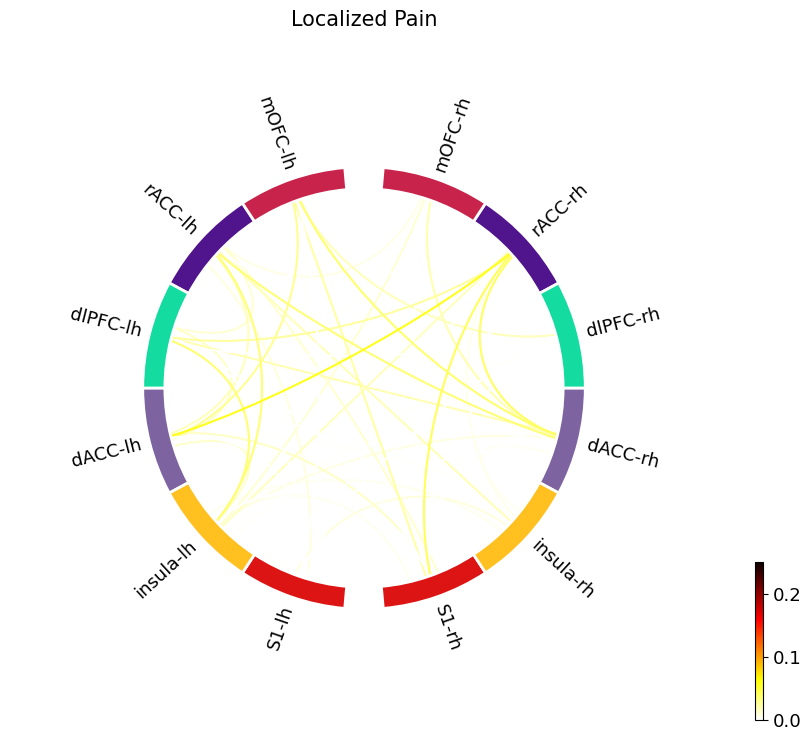

<Figure size 640x480 with 0 Axes>

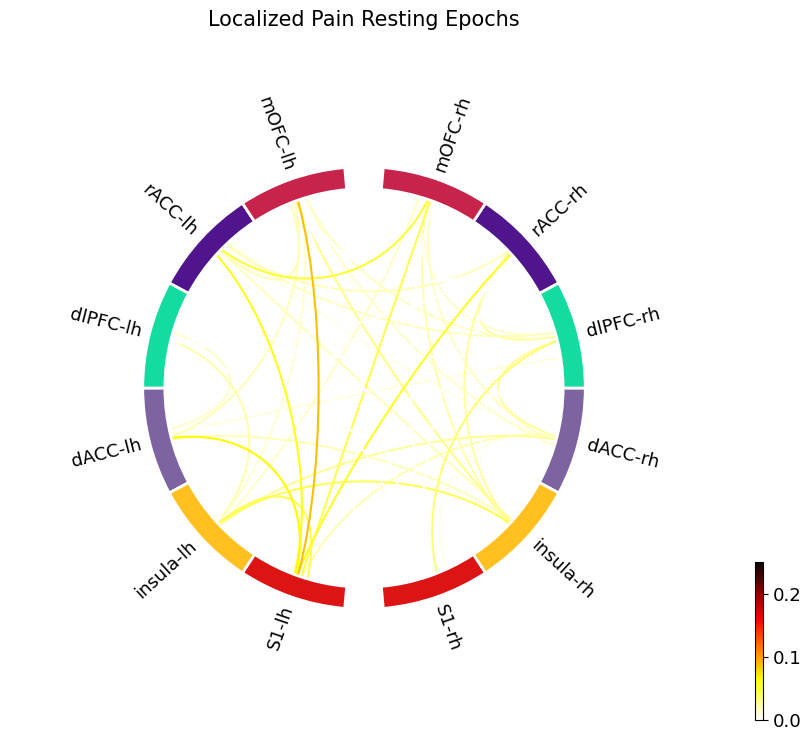

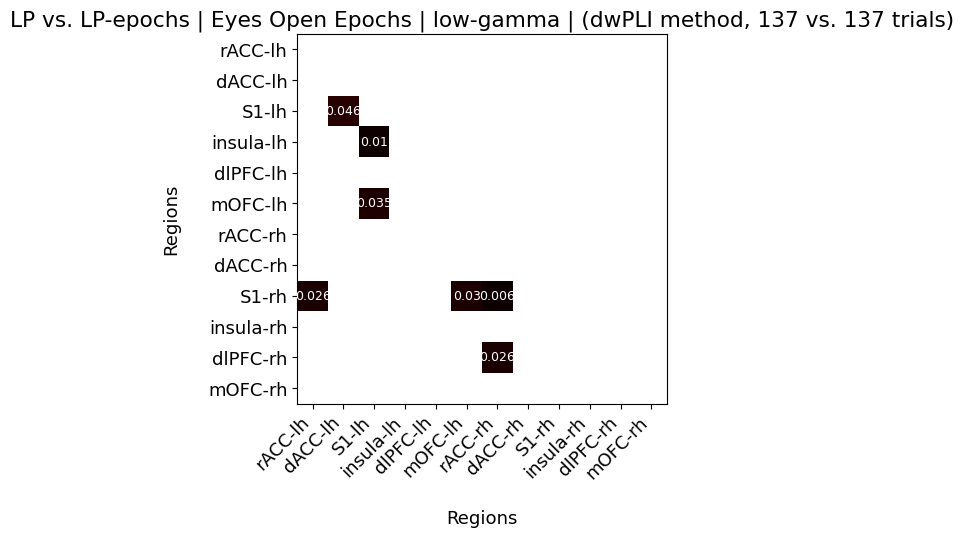

Hand 256 mN - Eyes Open Epochs - Localized Pain vs. Localized Pain Resting Epochs - wpli2_debiased - high-gamma
Top 3 Connections in Localized Pain group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
| mOFC-lh <-> insula-lh  |   2/12    |     0.169     |
| dlPFC-rh <-> insula-rh |   2/12    |     0.136     |
|   S1-lh <-> dACC-lh    |   2/12    |     0.144     |
+------------------------+-----------+---------------+ 

Top 3 Connections in Localized Pain Resting Epochs group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-rh <-> mOFC-lh |   3/12    |     0.22      |
| dACC-rh <-> dlPFC-lh  |   2/12    |     0.115     |
|  mOFC-rh <-> dACC-rh  |   2/12    |     0.128     |
+-----------------------+-----------+---------------+ 

(12, 12, 12)

Betweenn

<Figure size 640x480 with 0 Axes>

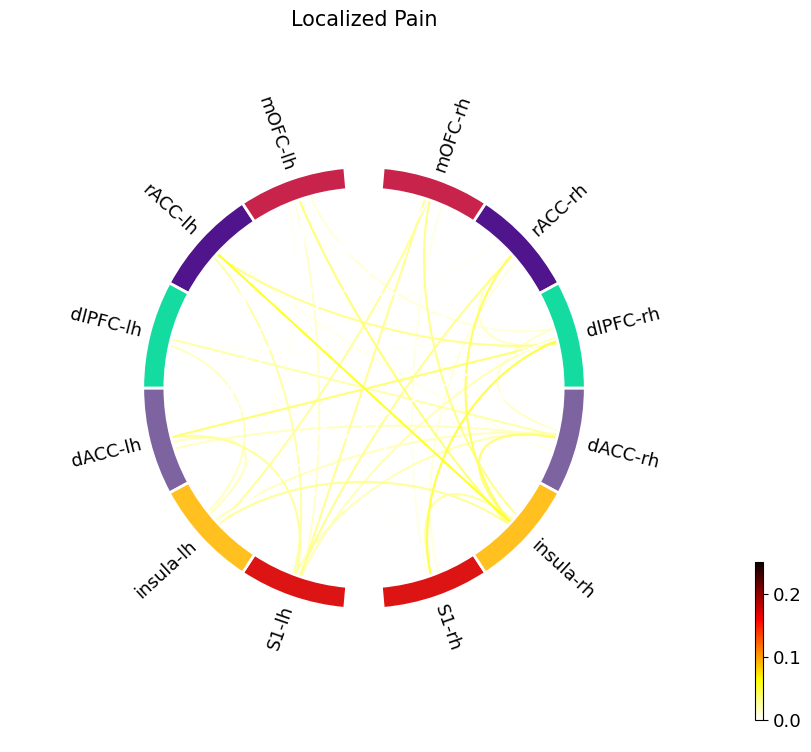

<Figure size 640x480 with 0 Axes>

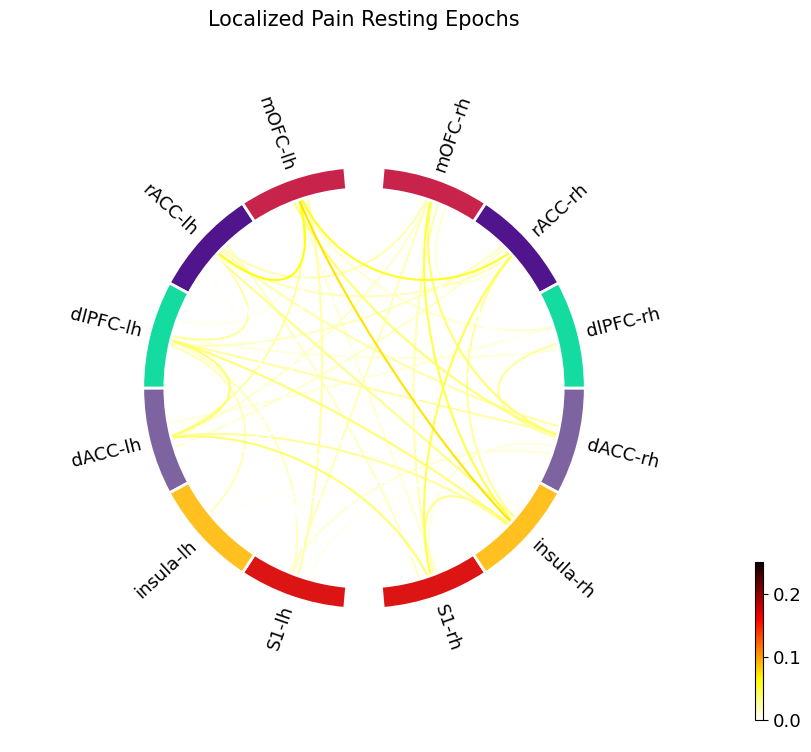

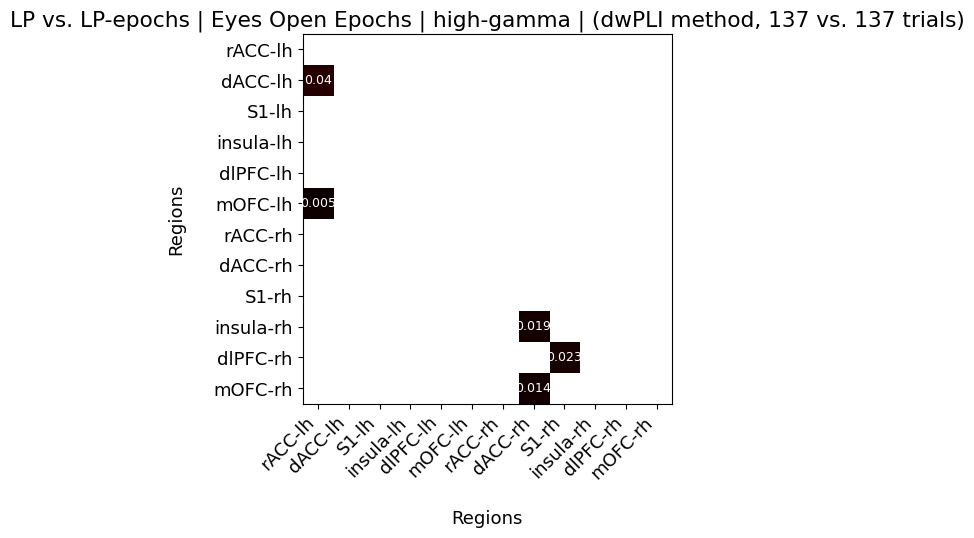

In [28]:
# Localized Pain vs. Localized Pain Epochs from Resting
these_group_names = ["Localized Pain", "Localized Pain Resting Epochs", "Mann_Whitney_U_test"]
these_group_cons = [group_con_LP, group_con_LP_epochs]
these_sub_cons = [sub_con_LP, sub_con_LP_epochs]
these_sub_ids = [sub_ids_LP, sub_ids_LP]
condition_LP =  'Hand 256 mN'
condition_LP_epochs = 'Eyes Open Epochs'
method = 'wpli2_debiased'

# Make a directory for the stats
stats_save_path = save_path / f"LP_vs_LP-epochs"
os.makedirs(stats_save_path, exist_ok=True)

for band in band_names:
    ## Save all output to a text file
    # Backup original stdout  
    orig_stdout = sys.stdout  
    if method=="wpli2_debiased":
        f = open(stats_save_path / f'{condition_LP}_{condition_LP_epochs}_{band}_dwPLI.txt', 'w')  
    else:
        f = open(stats_save_path / f'{condition_LP}_{condition_LP_epochs}_{band}_{method}.txt', 'w')
                
    # Set stdout to the file object  
    if save_txt:
        sys.stdout = f  
            
    # Select groups for mann-whitney
    print(f"{condition_LP} - {condition_LP_epochs} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
        
    # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
    top_3_info=None
    group_con=None
    for group_con,group_name,sub_con in zip(these_group_cons, these_group_names, these_sub_cons):
        table_data = []  
        if group_con == these_group_cons[0]:
            condition = condition_LP
        else:
            condition = condition_LP_epochs
        top_3_info = group_con[condition][method][band]["top 3"] 
        print(f"Top 3 Connections in {group_name} group")
        for i in range(3):  
            connection = top_3_info["connections"][i]  
            frequency = top_3_info["frequency"][i]  
            mean_strength = top_3_info["mean strength"][i]
            table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", f"{frequency}/{len(sub_con)}", mean_strength]) 
                
        # Define table headers  
        headers = ['Connection', 'Frequency', 'Mean Strength']  
                
        # Print the table  
        print(tabulate(table_data, headers, tablefmt='pretty'),'\n')  

    group1_stack = these_group_cons[0][condition_CP][method][band]["data"]
    print(group1_stack.shape)
    group2_stack = these_group_cons[1][condition_CP_epochs][method][band]["data"]

    nepochs_1 = these_group_cons[0][condition_CP]['num_epochs']
    nepochs_2 = these_group_cons[1][condition_CP_epochs]['num_epochs']
            
    # Compute the Mann-Whitney U test
    p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test_epochs(
        group1_stack,
        group2_stack,
        roi_acronyms=roi_acronyms,
        sub_ids1=these_sub_ids[0],
        sub_ids2=these_sub_ids[1],
        condition_group1=condition_LP,
        condition_group2=condition_LP_epochs,
        bilateral_pain_ids=bilateral_pain_ids,
        round_neg_vals=round_neg_vals,
        method=method)

    vmin = None
    vmax = None
            
    # Plotting
    # Gather the information for plotting
    plot_kwargs= dict(
        method=method,
        band=band, 
        roi_names=roi_names,
        roi_acronyms=roi_acronyms,
        condition=condition,
        vmin=vmin,
        vmax=vmax,
        group_names=these_group_names,
        nepochs=[nepochs_1, nepochs_2],
        titles=[these_group_names[0], 
                these_group_names[1],
                "LP vs. LP-epochs",],
        save_names=["Mann_Whitney_U_test",
                    these_group_names[0], 
                    these_group_names[1],
                    ],
            save_path=stats_save_path,
        )
            
    # Compute the centrality and test
    fc.compute_centrality_and_test(group1_stack,
                                    group2_stack, 
                                    roi_acronyms=roi_acronyms,
                                    sub_ids1=these_sub_ids[0],
                                    sub_ids2=these_sub_ids[1],
                                    bilateral_pain_ids=bilateral_pain_ids,
                                    condition=condition,
                                    )
           
    print(f"\nNum epochs: {nepochs_1} vs. {nepochs_2}")               
    fc.plot_connectivity_and_stats(means_1=means_1,
                                means_2=means_2,
                                sem_1=sem_1,
                                sem_2=sem_2,
                                p_values=p_values,
                                **plot_kwargs,
                                save_fig=True,
                                highlight_pvals=highlight_pvals,
                                min_fc_val=None,
                                set_title=set_title,
                                show_fc_vals=show_fc_vals,
                                round_neg_vals=round_neg_vals,
    )
    
        
    # Reset the standard output to its original value  
    sys.stdout = orig_stdout  
            
    f.close()  